# Credit Risk Modeling: PD Model Monitoring
*Author: Shawn Sun*
<br>
*Date: 2021/01/28*

## 1.0 Import Libraries and Data

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Import Train and Test Data.
loan_data_inputs_train = pd.read_csv('loan_data_inputs_train.csv', index_col = 0)
loan_data_targets_train = pd.read_csv('loan_data_targets_train.csv', index_col = 0)
loan_data_inputs_test = pd.read_csv('loan_data_inputs_test.csv', index_col = 0)
loan_data_targets_test = pd.read_csv('loan_data_targets_test.csv', index_col = 0)

In [3]:
# Import the new data.
loan_data_backup = pd.read_csv('loan_data_2015.csv')
loan_data = loan_data_backup.copy()

E:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (19,55) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## 2.0 Explore Data

In [4]:
pd.options.display.max_columns = None

In [5]:
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,68444620,73334399,35000,35000,35000.0,60 months,11.99,778.38,C,C1,Foreign Service Officer,10+ years,MORTGAGE,128000.0,Source Verified,Dec-15,Issued,n,https://www.lendingclub.com/browse/loanDetail....,NaN,home_improvement,Home improvement,200xx,DC,6.46,0.0,Feb-90,0.0,46.0,NaN,17.0,0.0,14277,27.4,46.0,w,35000.0,35000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Jan-16,Jan-16,0.0,56.0,1,INDIVIDUAL,NaN,NaN,NaN,0.0,321.0,146867.0,1.0,11.0,0.0,0.0,28.0,35367.0,49.3,0.0,1.0,5020.0,40.1,52200.0,1.0,4.0,0.0
1,68547583,73437441,8650,8650,8650.0,36 months,5.32,260.50,A,A1,Associate Consultant,< 1 year,MORTGAGE,100000.0,Not Verified,Dec-15,Issued,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,Credit card refinancing,462xx,IN,7.28,0.0,Jul-01,0.0,NaN,NaN,15.0,0.0,7158,26.7,24.0,w,8650.0,8650.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Jan-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,165450.0,0.0,1.0,1.0,1.0,11.0,24041.0,88.8,0.0,3.0,3081.0,57.9,26800.0,1.0,0.0,5.0
2,67849662,72708407,4225,4225,4225.0,36 months,14.85,146.16,C,C5,mechanic,5 years,RENT,35000.0,Source Verified,Dec-15,Issued,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,672xx,KS,15.22,2.0,Jul-11,0.0,18.0,NaN,6.0,0.0,1058,24.6,6.0,w,4225.0,4225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Jan-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,4888.0,0.0,1.0,0.0,0.0,47.0,3830.0,21.9,0.0,0.0,367.0,22.4,4300.0,0.0,0.0,0.0
3,68506885,73396712,10000,10000,10000.0,60 months,11.99,222.40,C,C1,CARDIOVASCULAR TECH,10+ years,RENT,42500.0,Not Verified,Dec-15,Issued,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,460xx,IN,31.04,0.0,Dec-98,1.0,NaN,NaN,10.0,0.0,5812,40.9,23.0,w,10000.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Jan-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,41166.0,1.0,3.0,0.0,2.0,13.0,35354.0,75.5,1.0,1.0,3118.0,67.4,14200.0,1.0,1.0,1.0
4,68341763,72928789,20000,20000,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-15,Issued,n,https://www.lendingclub.com/browse/loanDetail....,NaN,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-00,0.0,NaN,NaN,6.0,0.0,7869,56.2,18.0,w,20000.0,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Jan-16,Dec-15,0.0,NaN,1,JOINT,71000.0,13.85,Not Verified,0.0,0.0,189699.0,0.0,1.0,0.0,4.0,19.0,10827.0,72.8,0.0,2.0,2081.0,64.7,14000.0,2.0,5.0,1.0


In [6]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421094 entries, 0 to 421093
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           421094 non-null  int64  
 1   member_id                    421094 non-null  int64  
 2   loan_amnt                    421094 non-null  int64  
 3   funded_amnt                  421094 non-null  int64  
 4   funded_amnt_inv              421094 non-null  float64
 5   term                         421094 non-null  object 
 6   int_rate                     421094 non-null  float64
 7   installment                  421094 non-null  float64
 8   grade                        421094 non-null  object 
 9   sub_grade                    421094 non-null  object 
 10  emp_title                    397220 non-null  object 
 11  emp_length                   397277 non-null  object 
 12  home_ownership               421094 non-null  object 
 13 

# Population Stability Index: Preprocessing

### >>> The code from here to the other line starting with '>>>' is copied from the Data Preparation notebook, with minor adjustments. We have to perform the exact same data preprocessing, fine-classing, and coarse classing on the new data, in order to be able to calculate statistics for the exact same variables to the ones we used for training and testing the PD model.

### 2.1 Preprocessing continuous variables

#### Process 'employment length'

In [7]:
loan_data['emp_length'].unique()

array(['10+ years', '< 1 year', '5 years', '3 years', '4 years', nan,
       '2 years', '8 years', '9 years', '1 year', '6 years', '7 years'],
      dtype=object)

In [8]:
loan_data['emp_length_int'] = \
loan_data['emp_length'].str.replace('\+ years', '')
loan_data['emp_length_int'] = \
loan_data['emp_length_int'].str.replace('< 1 year', str(0))
loan_data['emp_length_int'] = \
loan_data['emp_length_int'].str.replace('n/a',  str(0))
loan_data['emp_length_int'] = \
loan_data['emp_length_int'].str.replace(' years', '')
loan_data['emp_length_int'] = \
loan_data['emp_length_int'].str.replace(' year', '')
#Replace the text/blank strings to null; for example: '+ years','year', etc.

In [9]:
type(loan_data['emp_length_int'][0])
# Checks the datatype of a single element of a column.

str

In [10]:
loan_data['emp_length_int'] = pd.to_numeric(loan_data['emp_length_int'])
# Transforms the values to numeric.

In [11]:
type(loan_data['emp_length_int'][0])
# Checks the datatype of converted column

numpy.float64

#### Process 'term'

In [12]:
loan_data['term'].unique()

array([' 60 months', ' 36 months'], dtype=object)

In [13]:
loan_data['term_int'] = loan_data['term'].str.replace(' ','')
loan_data['term_int'] = loan_data['term'].str.replace('months','')

In [14]:
loan_data['term_int'] = pd.to_numeric(loan_data['term_int'])
type(loan_data['term_int'][0])

numpy.int64

#### Process ' earliest credit line'

In [15]:
loan_data['earliest_cr_line'].head()

0    Feb-90
1    Jul-01
2    Jul-11
3    Dec-98
4    Aug-00
Name: earliest_cr_line, dtype: object

In [16]:
loan_data['earliest_cr_line_date'] = \
pd.to_datetime(loan_data['earliest_cr_line'], format = '%b-%y')
#Convert string values to time values

In [17]:
type(loan_data['earliest_cr_line_date'][0])
# Checks the datatype of converted column

pandas._libs.tslibs.timestamps.Timestamp

In [18]:
pd.to_datetime('2017-12-01') - loan_data['earliest_cr_line_date']
# Assume we are now in December 2017
# Calculates the difference between two dates and times.

0        10165 days
1         5997 days
2         2345 days
3         6940 days
4         6331 days
            ...    
421089    4839 days
421090   15981 days
421091    5205 days
421092    5175 days
421093    5844 days
Name: earliest_cr_line_date, Length: 421094, dtype: timedelta64[ns]

In [19]:
loan_data['mths_since_earliest_cr_line'] = \
round(pd.to_numeric((pd.to_datetime('2017-12-01') - \
                     loan_data['earliest_cr_line_date']) / \
                    np.timedelta64(1, 'M')))
# We calculate the difference between two dates in months,
#  turn it to numeric datatype and round it.
# We save the result in a new variable.

In [20]:
loan_data['mths_since_earliest_cr_line'].describe()

count    421094.000000
mean        227.354876
std          98.123989
min        -612.000000
25%         167.000000
50%         212.000000
75%         277.000000
max         587.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [21]:
loan_data.loc[: , ['earliest_cr_line', \
                   'earliest_cr_line_date', \
                   'mths_since_earliest_cr_line']]\
[loan_data['mths_since_earliest_cr_line'] < 0]
# We take three columns from the dataframe. 
# Then, we display them only for the rows where a variable has negative value.

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
254,Jan-57,2057-01-01,-469.0
618,Aug-64,2064-08-01,-560.0
648,Jul-68,2068-07-01,-607.0
1808,Jan-65,2065-01-01,-565.0
2583,Sep-64,2064-09-01,-561.0
...,...,...,...
418890,Jun-68,2068-06-01,-606.0
420450,Jan-66,2066-01-01,-577.0
420642,Sep-68,2068-09-01,-609.0
420794,Sep-65,2065-09-01,-573.0


In [22]:
loan_data['mths_since_earliest_cr_line']\
[loan_data['mths_since_earliest_cr_line'] < 0] = \
loan_data['mths_since_earliest_cr_line'].max()
# We set the rows that had negative differences to the maximum value.

<ipython-input-22-3c3aa52c2a4a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data['mths_since_earliest_cr_line']\


In [23]:
min(loan_data['mths_since_earliest_cr_line'])
# Checkthe minimum value of a column.

61.0

#### Process ' issue date'

In [24]:
loan_data['issue_d'].head()

0    Dec-15
1    Dec-15
2    Dec-15
3    Dec-15
4    Dec-15
Name: issue_d, dtype: object

In [25]:
loan_data['issue_d_date'] = pd.to_datetime(loan_data['issue_d'],format = '%b-%y')
type(loan_data['issue_d_date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [26]:
loan_data['mths_since_issue_d'] = \
round(pd.to_numeric((pd.to_datetime('2017-12-01')\
                     - loan_data['issue_d_date']) / np.timedelta64(1,'M')))
loan_data['mths_since_issue_d'].describe()

count    421094.000000
mean         29.044629
std           3.458162
min          24.000000
25%          26.000000
50%          29.000000
75%          32.000000
max          35.000000
Name: mths_since_issue_d, dtype: float64

### 2.2 Preprocessing discrete variables

In [27]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421094 entries, 0 to 421093
Data columns (total 80 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   id                           421094 non-null  int64         
 1   member_id                    421094 non-null  int64         
 2   loan_amnt                    421094 non-null  int64         
 3   funded_amnt                  421094 non-null  int64         
 4   funded_amnt_inv              421094 non-null  float64       
 5   term                         421094 non-null  object        
 6   int_rate                     421094 non-null  float64       
 7   installment                  421094 non-null  float64       
 8   grade                        421094 non-null  object        
 9   sub_grade                    421094 non-null  object        
 10  emp_title                    397220 non-null  object        
 11  emp_length                

In [28]:
loan_data_dummies = [pd.get_dummies(loan_data['grade'], prefix = 'grade', prefix_sep = ':'),
                     pd.get_dummies(loan_data['sub_grade'], prefix = 'sub_grade', prefix_sep = ':'),
                     pd.get_dummies(loan_data['home_ownership'], prefix = 'home_ownership', prefix_sep = ':'),
                     pd.get_dummies(loan_data['verification_status'], prefix = 'verification_status', prefix_sep = ':'),
                     pd.get_dummies(loan_data['loan_status'], prefix = 'loan_status', prefix_sep = ':'),
                     pd.get_dummies(loan_data['purpose'], prefix = 'purpose', prefix_sep = ':'),
                     pd.get_dummies(loan_data['addr_state'], prefix = 'addr_state', prefix_sep = ':'),
                     pd.get_dummies(loan_data['initial_list_status'], prefix = 'initial_list_status', prefix_sep = ':')]
# We create dummy variables from all 8 original independent variables, and save them into a list.
# Note that we are using a particular naming convention for all variables: original variable name, colon, category name.

In [29]:
loan_data_dummies = pd.concat(loan_data_dummies, axis = 1)

In [30]:
loan_data_dummies.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Issued,loan_status:Late (16-30 days),loan_status:Late (31-120 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:ND,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [31]:
loan_data = pd.concat([loan_data, loan_data_dummies], axis = 1)
# Concatenates two dataframes
loan_data.columns.values

array(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
       'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint

### 2.3 Check for missing values

In [32]:
loan_data.isnull()
# returns True if a values is missing

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,emp_length_int,term_int,earliest_cr_line_date,mths_since_earliest_cr_line,issue_d_date,mths_since_issue_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Issued,loan_status:Late (16-30 days),loan_status:Late (31-120 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:ND,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [33]:
pd.options.display.max_rows = None
loan_data.isnull().sum()

id                                          0
member_id                                   0
loan_amnt                                   0
funded_amnt                                 0
funded_amnt_inv                             0
term                                        0
int_rate                                    0
installment                                 0
grade                                       0
sub_grade                                   0
emp_title                               23874
emp_length                              23817
home_ownership                              0
annual_inc                                  0
verification_status                         0
issue_d                                     0
loan_status                                 0
pymnt_plan                                  0
url                                         0
desc                                   421049
purpose                                     0
title                             

#### For 'Total revolving high credit limit'

In [34]:
loan_data['total_rev_hi_lim'].fillna(loan_data['funded_amnt'], inplace=True)
# missing'total revolving high credit limit' = 'funded amount'

loan_data['total_rev_hi_lim'].isnull().sum()
# Check if missing values remained

0

#### For 'Annual income'

In [35]:
loan_data['annual_inc'].fillna(loan_data['annual_inc'].mean(),inplace = True)
# missing'annual income' = average of 'annual income'

loan_data['total_rev_hi_lim'].isnull().sum()
# Check if missing values remained

0

#### For other missing values

In [36]:
loan_data['mths_since_earliest_cr_line'].fillna(0, inplace=True)
loan_data['acc_now_delinq'].fillna(0, inplace=True)
loan_data['total_acc'].fillna(0, inplace=True)
loan_data['pub_rec'].fillna(0, inplace=True)
loan_data['open_acc'].fillna(0, inplace=True)
loan_data['inq_last_6mths'].fillna(0, inplace=True)
loan_data['delinq_2yrs'].fillna(0, inplace=True)
loan_data['emp_length_int'].fillna(0, inplace=True)
# Other missing values = 0

## 3.0 PD Model

### 3.1 PD Model: Data Preparation

#### Create dummy variables for dependent variable: loan_status -> 'good/bad' indicator

In [37]:
loan_data['loan_status'].unique()

array(['Issued', 'Current', 'Fully Paid', 'In Grace Period',
       'Late (16-30 days)', 'Late (31-120 days)', 'Charged Off',
       'Default'], dtype=object)

In [38]:
loan_data['loan_status'].value_counts() / loan_data['loan_status'].count()
# get the proportion of observations for each unique value of a variable

Current               0.896600
Fully Paid            0.054582
Issued                0.020091
Late (31-120 days)    0.011140
In Grace Period       0.007378
Charged Off           0.006585
Late (16-30 days)     0.002705
Default               0.000919
Name: loan_status, dtype: float64

In [39]:
loan_data['good_bad'] = \
np.where(loan_data['loan_status'].\
         isin(['Charged Off', 'Default',
               'Does not meet the credit policy. Status:Charged Off',
               'Late (31-120 days)']), 0, 1)
#create a new variable that has the value of '0' if a condition is met, 
# and the value of '1' if it is no
# pd.options.display.max_rows = None
loan_data['good_bad'].head()

0    1
1    1
2    1
3    1
4    1
Name: good_bad, dtype: int32

In [40]:
pd.options.display.max_rows = 30

#### Splitting data for train and test

In [41]:
#from sklearn.model_selection import train_test_split
# Imports the library needed

In [42]:
#loan_data_inputs_train, loan_data_inputs_test, \
#loan_data_targets_train, loan_data_targets_test = \
#train_test_split(loan_data.drop('good_bad', axis = 1), \
#                 loan_data['good_bad'], test_size = 0.2, random_state = 42)
# Split two dataframes with inputs and targets, 
#   each into a train and test dataframe, and store them in variables.
# Set the size of the test dataset to be 20%.

# Set a specific random state.
#  Allow us to perform the exact same split multimple times.
#  To assign the exact same observations to the train and test datasets.

In [43]:
#loan_data_inputs_train.shape

In [44]:
#loan_data_targets_train.shape

In [45]:
#loan_data_inputs_test.shape

In [46]:
#loan_data_targets_test.shape

In [47]:
#####
#df_inputs_prepr = loan_data_inputs_train
#df_targets_prepr = loan_data_targets_train
#####
#df_inputs_prepr = loan_data_inputs_test
#df_targets_prepr = loan_data_targets_test

In [48]:
df_inputs_prepr = loan_data.drop('good_bad', axis = 1)
df_targets_prepr = loan_data['good_bad']

#### Function for discrete variables: calculate 'weight of eveidence' and 'information value'

In [49]:
# WoE function for discrete unordered variables
def woe_discrete(df, discrete_variabe_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variabe_name], good_bad_variable_df], axis = 1)
    # Only store the independent and dependent variables
    
    df = pd.concat([df.groupby(df.columns.values[0], 
                               as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], 
                               as_index = False)[df.columns.values[1]].mean()], 
                   axis = 1)
    # Group the df by value in first column
    # Add the number and mean of good_bad obs of each kind
    
    df = df.iloc[:, [0, 1, 3]]
    # Remove the 3rd column
    
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    # Rename the columns
    
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    # Calculate proportions of each kind
    
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
     # Calculate the number of good and bad borrowers of each kind
        
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    # Calculate the proportions of good and bad borrowers of each kind
    
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    # Calculate the weight of evidence of each kind
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    # Sort the dataframes by WoE, and replace the index with increasing numbers
    
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    # Calculate the difference of certain variable between the nearby kinds
    
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    #Calculatet he information value of each kind
    
    return df
# The function takes 3 arguments: a dataframe, a string, and a dataframe. 
#  The function returns a dataframe as a result.

In [50]:
df_temp = woe_discrete(df_inputs_prepr, 'grade', df_targets_prepr)
df_temp

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,G,2167,0.904015,0.005146,1959.0,208.0,0.004741,0.026493,-1.720744,NaN,NaN,0.633941
1,F,9817,0.930529,0.023313,9135.0,682.0,0.022106,0.086868,-1.368556,0.026514,0.352187,0.633941
2,E,34948,0.956936,0.082993,33443.0,1505.0,0.080928,0.191695,-0.862345,0.026407,0.506211,0.633941
3,D,62654,0.967488,0.148789,60617.0,2037.0,0.146686,0.259457,-0.570298,0.010552,0.292048,0.633941
4,C,120567,0.982541,0.286318,118462.0,2105.0,0.286664,0.268119,0.066882,0.015053,0.637180,0.633941
5,B,117606,0.991097,0.279287,116559.0,1047.0,0.282059,0.133359,0.749074,0.008557,0.682192,0.633941
6,A,73335,0.996359,0.174154,73068.0,267.0,0.176816,0.034008,1.648502,0.005262,0.899428,0.633941


#### Function: visualize weight of evidence

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# Set the default style of the graphs to the seaborn style

In [52]:
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    # Turns the values of the first column to strings, 
    #   makes an array from these strings, and passes it to variable x
    y = df_WoE['WoE']
    # Selects a column with label 'WoE' and passes it to variable y
    plt.figure(figsize=(18, 6))
    # Sets the graph size to width 18 x height 6.
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    # Plots the datapoints with coordiantes variable x on the x-axis 
    #  and variable y on the y-axis
    # Sets the marker for each datapoint to a circle, 
    #  the style line between the points to dashed, and the color to black
    plt.xlabel(df_WoE.columns[0])
    # Names the x-axis with the name of the first column
    plt.ylabel('Weight of Evidence')
    # Names the y-axis 'Weight of Evidence'.
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    # Names the grapth 'Weight of Evidence by ' the name of the column with index 0.
    plt.xticks(rotation = rotation_of_x_axis_labels)
    # Rotates the labels of the x-axis a predefined number of degrees

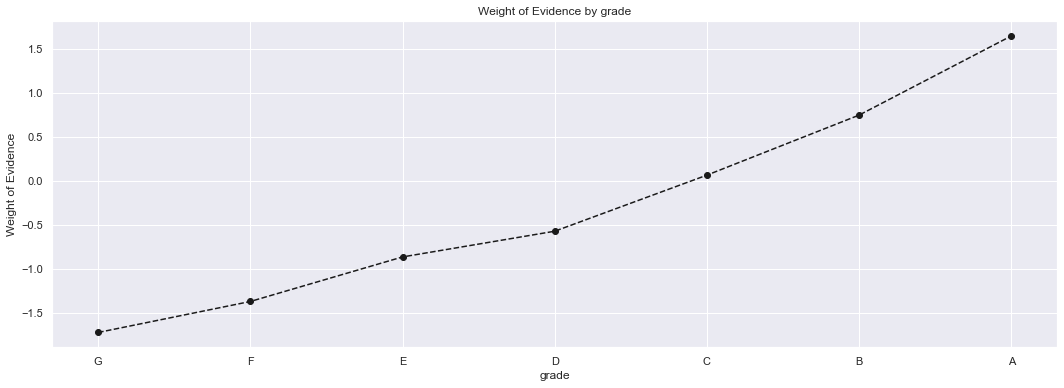

In [53]:
plot_by_woe(df_temp)

#### Create dummy variables: 'home ownership' (discrete)

In [54]:
df_temp = woe_discrete(df_inputs_prepr, 'home_ownership', df_targets_prepr)
df_temp

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,RENT,167644,0.976933,0.398115,163777.0,3867.0,0.396321,0.492549,-0.217368,NaN,NaN,inf
1,OWN,45766,0.980750,0.108684,44885.0,881.0,0.108616,0.112215,-0.032594,0.003817,0.184775,inf
2,MORTGAGE,207682,0.985059,0.493196,204579.0,3103.0,0.495057,0.395236,0.225190,0.004309,0.257784,inf
3,ANY,2,1.000000,0.000005,2.0,0.0,0.000005,0.000000,inf,0.014941,inf,inf


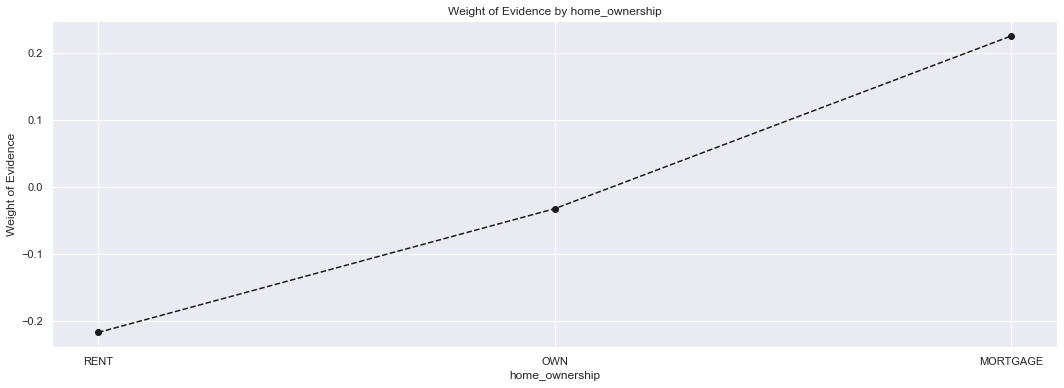

In [55]:
plot_by_woe(df_temp)

In [56]:
loan_data['home_ownership'].unique()

array(['MORTGAGE', 'RENT', 'OWN', 'ANY'], dtype=object)

In [57]:
# 'OTHERS' and 'NONE' are riskiest but are very few
# 'RENT' is the next riskiest.
# 'ANY' are least risky but are too few. 
# -> Conceptually, they belong to the same category. 
#    Also, their inclusion would not change anything.
# -> We combine them in one category, 'RENT_OTHER_NONE_ANY'.
#    We end up with 3 categories: 'RENT_OTHER_NONE_ANY', 'OWN', 'MORTGAGE'.

df_inputs_prepr['home_ownership:RENT_OTHER_NONE_ANY'] = \
sum([df_inputs_prepr['home_ownership:RENT'], 
     df_inputs_prepr['home_ownership:ANY']])

#### Create dummy variables: 'addr_state' (discrete)

In [58]:
df_temp = woe_discrete(df_inputs_prepr, 'addr_state', df_targets_prepr)
df_temp

,addr_state,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,NV,5924,0.969953,0.014068,5746.0,178.0,0.013905,0.022672,-0.488919,NaN,NaN,inf
1,SD,835,0.970060,0.001983,810.0,25.0,0.001960,0.003184,-0.485236,0.000107,0.003683,inf
2,HI,2083,0.973596,0.004947,2028.0,55.0,0.004908,0.007005,-0.355923,0.003536,0.129314,inf
3,OK,3968,0.976310,0.009423,3874.0,94.0,0.009375,0.011973,-0.244647,0.002715,0.111276,inf
4,AK,954,0.977987,0.002266,933.0,21.0,0.002258,0.002675,-0.169512,0.001677,0.075135,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
44,VT,892,0.992152,0.002118,885.0,7.0,0.002142,0.000892,0.876283,0.003087,0.334830,inf
45,NH,2062,0.994180,0.004897,2050.0,12.0,0.004961,0.001528,1.177294,0.002028,0.301011,inf
46,NE,1162,0.994836,0.002759,1156.0,6.0,0.002797,0.000764,1.297567,0.000656,0.120273,inf
47,ND,479,0.997912,0.001138,478.0,1.0,0.001157,0.000127,2.206216,0.003076,0.908649,inf


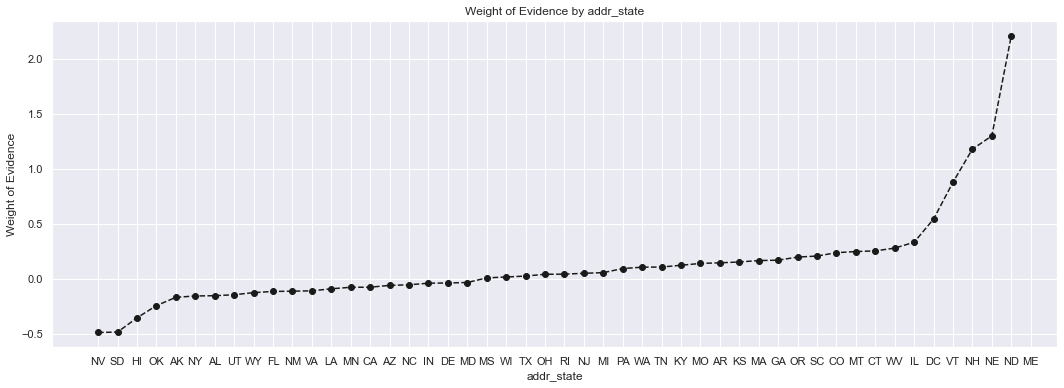

In [59]:
plot_by_woe(df_temp)

In [60]:
# Since ND might be missing in dataframe
if ['addr_state:ND'] in df_inputs_prepr.columns.values:
    pass
else:
    df_inputs_prepr['addr_state:ND'] = 0

In [61]:
if ['addr_state:ID'] in df_inputs_prepr.columns.values:
    pass
else:
    df_inputs_prepr['addr_state:ID'] = 0

In [62]:
if ['addr_state:IA'] in df_inputs_prepr.columns.values:
    pass
else:
    df_inputs_prepr['addr_state:IA'] = 0

In [63]:
# We create the following categories:
# 'ND' 'NE' 'IA' NV' 'FL' 'HI' 'AL'
# 'NM' 'VA'
# 'NY'
# 'OK' 'TN' 'MO' 'LA' 'MD' 'NC'
# 'CA'
# 'UT' 'KY' 'AZ' 'NJ'
# 'AR' 'MI' 'PA' 'OH' 'MN'
# 'RI' 'MA' 'DE' 'SD' 'IN'
# 'GA' 'WA' 'OR'
# 'WI' 'MT'
# 'TX'
# 'IL' 'CT'
# 'KS' 'SC' 'CO' 'VT' 'AK' 'MS'
# 'WV' 'NH' 'WY' 'DC' 'ME' 'ID'

# 'IA_NV_HI_ID_AL_FL' will be the reference category.

df_inputs_prepr['addr_state:ND_NE_IA_NV_FL_HI_AL'] = \
sum([df_inputs_prepr['addr_state:ND'], df_inputs_prepr['addr_state:NE'], 
     df_inputs_prepr['addr_state:IA'], df_inputs_prepr['addr_state:NV'],
     df_inputs_prepr['addr_state:FL'], df_inputs_prepr['addr_state:HI'],
     df_inputs_prepr['addr_state:AL']])

df_inputs_prepr['addr_state:NM_VA'] = \
sum([df_inputs_prepr['addr_state:NM'], df_inputs_prepr['addr_state:VA']])

df_inputs_prepr['addr_state:OK_TN_MO_LA_MD_NC'] = \
sum([df_inputs_prepr['addr_state:OK'], df_inputs_prepr['addr_state:TN'],
     df_inputs_prepr['addr_state:MO'], df_inputs_prepr['addr_state:LA'],
     df_inputs_prepr['addr_state:MD'], df_inputs_prepr['addr_state:NC']])

df_inputs_prepr['addr_state:UT_KY_AZ_NJ'] = \
sum([df_inputs_prepr['addr_state:UT'], df_inputs_prepr['addr_state:KY'],
     df_inputs_prepr['addr_state:AZ'], df_inputs_prepr['addr_state:NJ']])

df_inputs_prepr['addr_state:AR_MI_PA_OH_MN'] = \
sum([df_inputs_prepr['addr_state:AR'], df_inputs_prepr['addr_state:MI'],
     df_inputs_prepr['addr_state:PA'], df_inputs_prepr['addr_state:OH'],
     df_inputs_prepr['addr_state:MN']])

df_inputs_prepr['addr_state:RI_MA_DE_SD_IN'] = \
sum([df_inputs_prepr['addr_state:RI'], df_inputs_prepr['addr_state:MA'],
     df_inputs_prepr['addr_state:DE'], df_inputs_prepr['addr_state:SD'],
     df_inputs_prepr['addr_state:IN']])

df_inputs_prepr['addr_state:GA_WA_OR'] = \
sum([df_inputs_prepr['addr_state:GA'], df_inputs_prepr['addr_state:WA'],
     df_inputs_prepr['addr_state:OR']])

df_inputs_prepr['addr_state:WI_MT'] = \
sum([df_inputs_prepr['addr_state:WI'], df_inputs_prepr['addr_state:MT']])

df_inputs_prepr['addr_state:IL_CT'] = \
sum([df_inputs_prepr['addr_state:IL'], df_inputs_prepr['addr_state:CT']])

df_inputs_prepr['addr_state:KS_SC_CO_VT_AK_MS'] = \
sum([df_inputs_prepr['addr_state:KS'], df_inputs_prepr['addr_state:SC'],
     df_inputs_prepr['addr_state:CO'], df_inputs_prepr['addr_state:VT'],
     df_inputs_prepr['addr_state:AK'], df_inputs_prepr['addr_state:MS']])

df_inputs_prepr['addr_state:WV_NH_WY_DC_ME_ID'] = \
sum([df_inputs_prepr['addr_state:WV'], df_inputs_prepr['addr_state:NH'],
     df_inputs_prepr['addr_state:WY'], df_inputs_prepr['addr_state:DC'],
     df_inputs_prepr['addr_state:ME'], df_inputs_prepr['addr_state:ID']])

#### Create dummy variables: 'verification_status' (discrete)

In [64]:
df_temp = woe_discrete(df_inputs_prepr, 'verification_status', df_targets_prepr)
df_temp

,verification_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Verified,123016,0.976532,0.292134,120129.0,2887.0,0.290698,0.367724,-0.235047,NaN,NaN,0.046808
1,Source Verified,179565,0.981110,0.426425,176173.0,3392.0,0.426318,0.432047,-0.013348,0.004578,0.221698,0.046808
2,Not Verified,118513,0.986736,0.281441,116941.0,1572.0,0.282984,0.200229,0.345926,0.005626,0.359274,0.046808


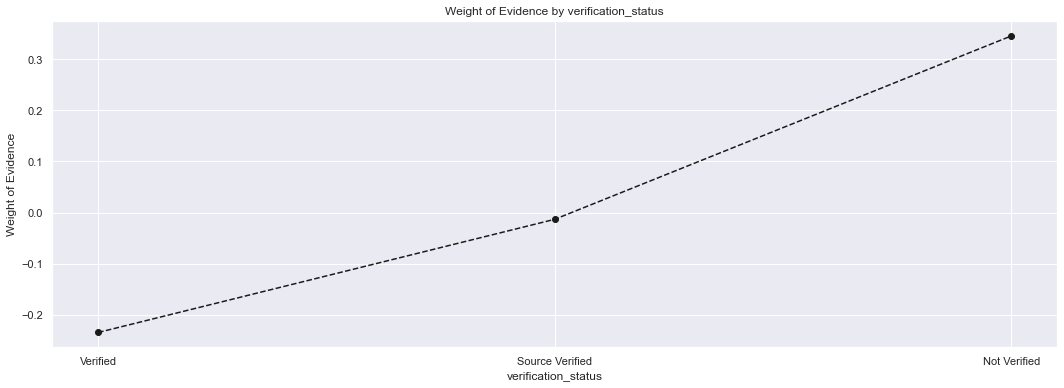

In [65]:
plot_by_woe(df_temp)

#### Create dummy variables: 'purpose' (discrete)

In [66]:
df_temp = woe_discrete(df_inputs_prepr, 'purpose', df_targets_prepr)
df_temp

,purpose,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,wedding,4,0.750000,0.000009,3.0,1.0,0.000007,0.000127,-2.864783,NaN,NaN,inf
1,renewable_energy,224,0.955357,0.000532,214.0,10.0,0.000518,0.001274,-0.900004,0.205357,1.964779,inf
2,small_business,3364,0.958680,0.007989,3225.0,139.0,0.007804,0.017705,-0.819181,0.003323,0.080823,inf
3,moving,2420,0.965289,0.005747,2336.0,84.0,0.005653,0.010699,-0.638016,0.006609,0.181164,inf
4,house,1438,0.967316,0.003415,1391.0,47.0,0.003366,0.005986,-0.575764,0.002026,0.062252,inf
5,medical,3938,0.970797,0.009352,3823.0,115.0,0.009251,0.014648,-0.459536,0.003482,0.116228,inf
6,major_purchase,7449,0.975970,0.017690,7270.0,179.0,0.017593,0.022800,-0.259269,0.005173,0.200267,inf
7,other,19204,0.976672,0.045605,18756.0,448.0,0.045387,0.057063,-0.228919,0.000702,0.030350,inf
8,vacation,2249,0.977768,0.005341,2199.0,50.0,0.005321,0.006369,-0.179660,0.001096,0.049259,inf
9,debt_consolidation,250020,0.979878,0.593739,244989.0,5031.0,0.592845,0.640810,-0.077800,0.002110,0.101860,inf


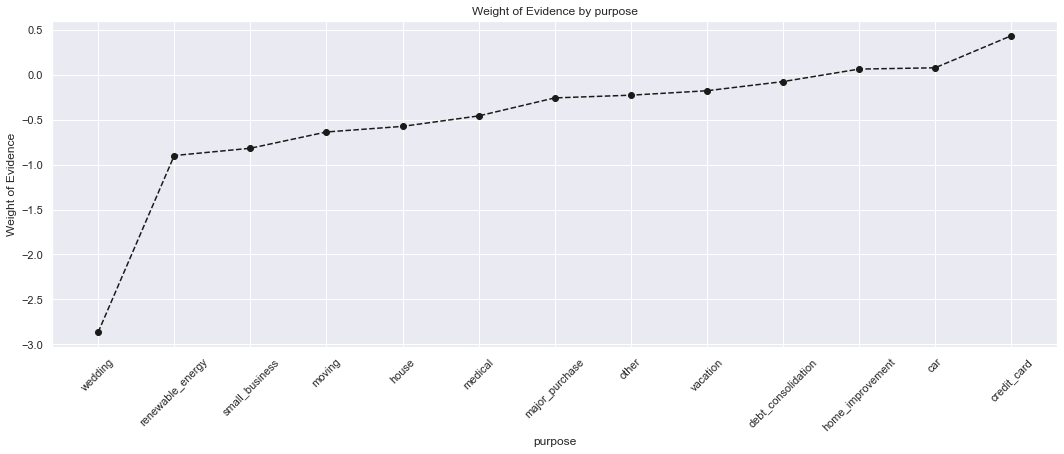

In [67]:
plot_by_woe(df_temp,45)

In [68]:
# Combine 'educational', 'small_business', 'wedding', 'renewable_energy', 
#   'moving', 'house' in one category: 'educ__sm_b__wedd__ren_en__mov__house'.
# Combine 'other', 'medical', 'vacation' in one category: 'oth__med__vacation'.
# Combine 'major_purchase', 'car', 'home_improvement' in one category: 'major_purch__car__home_impr'.
# Leave 'debt_consolidtion' in a separate category.
# Leave 'credit_card' in a separate category.
# 'educ__sm_b__wedd__ren_en__mov__house' will be the reference category.
df_inputs_prepr['purpose:educ__sm_b__wedd__ren_en__mov__house'] = \
sum([df_inputs_prepr['purpose:educational'], df_inputs_prepr['purpose:small_business'],
     df_inputs_prepr['purpose:wedding'], df_inputs_prepr['purpose:renewable_energy'],
     df_inputs_prepr['purpose:moving'], df_inputs_prepr['purpose:house']])
df_inputs_prepr['purpose:oth__med__vacation'] = \
sum([df_inputs_prepr['purpose:other'], df_inputs_prepr['purpose:medical'],
     df_inputs_prepr['purpose:vacation']])
df_inputs_prepr['purpose:major_purch__car__home_impr'] = \
sum([df_inputs_prepr['purpose:major_purchase'], df_inputs_prepr['purpose:car'],
     df_inputs_prepr['purpose:home_improvement']])

#### Create dummy variables: 'initial_list_status' (discrete)

In [69]:
df_temp = woe_discrete(df_inputs_prepr, 'initial_list_status', df_targets_prepr)
df_temp

,initial_list_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,f,153843,0.972550,0.365341,149620.0,4223.0,0.362063,0.537893,-0.395842,NaN,NaN,0.126296
1,w,267251,0.986425,0.634659,263623.0,3628.0,0.637937,0.462107,0.322444,0.013875,0.718286,0.126296


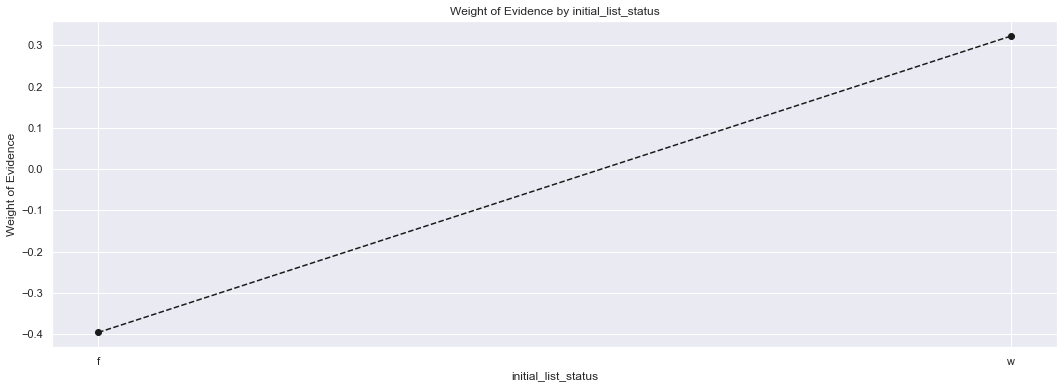

In [70]:
plot_by_woe(df_temp)

#### Function for continuous variables

In [71]:
# WoE function for ordered discrete and continuous variables
def woe_ordered_continuous(df, discrete_variabe_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variabe_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

#### 'term_int' (continuous)

In [72]:
df_inputs_prepr['term_int'].unique()

array([60, 36], dtype=int64)

In [73]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'term_int', df_targets_prepr)
df_temp

,term_int,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,36,283172,0.983533,0.672467,278509.0,4663.0,0.673959,0.593937,0.126396,NaN,NaN,0.027678
1,60,137922,0.976885,0.327533,134734.0,3188.0,0.326041,0.406063,-0.219486,0.006647,0.345883,0.027678


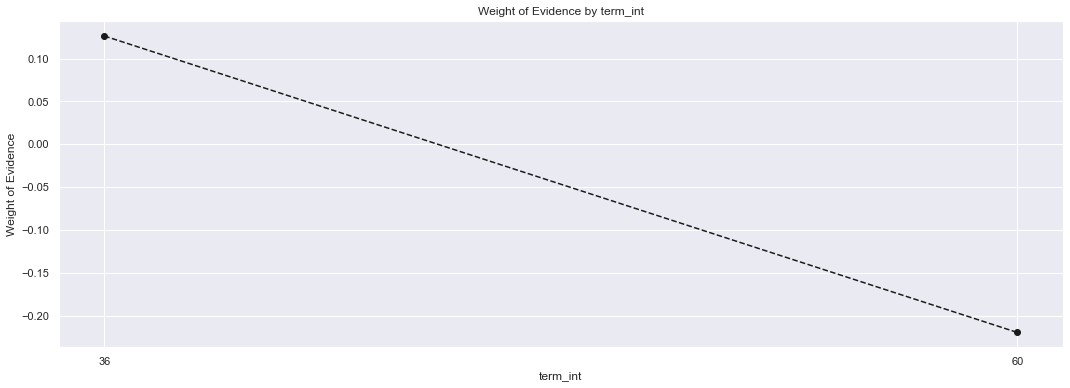

In [74]:
plot_by_woe(df_temp)

In [75]:
df_inputs_prepr['term:36'] = np.where((df_inputs_prepr['term_int'] == 36), 1, 0)
df_inputs_prepr['term:60'] = np.where((df_inputs_prepr['term_int'] == 60), 1, 0)

#### 'emp_length_int'

In [76]:
df_inputs_prepr['emp_length_int'].unique()

array([10.,  0.,  5.,  3.,  4.,  2.,  8.,  9.,  1.,  6.,  7.])

In [77]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'emp_length_int', df_targets_prepr)
df_temp

,emp_length_int,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,58157,0.977733,0.138109,56862.0,1295.0,0.137599,0.164947,-0.181278,NaN,NaN,0.019134
1,1.0,27473,0.977687,0.065242,26860.0,613.0,0.064998,0.078079,-0.183366,0.000046,0.002088,0.019134
2,2.0,37497,0.980932,0.089047,36782.0,715.0,0.089008,0.091071,-0.022914,0.003245,0.160453,0.019134
3,3.0,33430,0.980975,0.079388,32794.0,636.0,0.079358,0.081009,-0.020593,0.000043,0.002321,0.019134
4,4.0,24506,0.979678,0.058196,24008.0,498.0,0.058097,0.063431,-0.087853,0.001297,0.067260,0.019134
5,5.0,24930,0.980866,0.059203,24453.0,477.0,0.059173,0.060757,-0.026403,0.001188,0.061449,0.019134
6,6.0,16838,0.978976,0.039986,16484.0,354.0,0.039889,0.045090,-0.122546,0.001890,0.096143,0.019134
7,7.0,18414,0.979201,0.043729,18031.0,383.0,0.043633,0.048784,-0.111582,0.000224,0.010964,0.019134
8,8.0,21560,0.983905,0.051200,21213.0,347.0,0.051333,0.044198,0.149650,0.004705,0.261232,0.019134
9,9.0,16769,0.982289,0.039822,16472.0,297.0,0.039860,0.037830,0.052290,0.001617,0.097360,0.019134


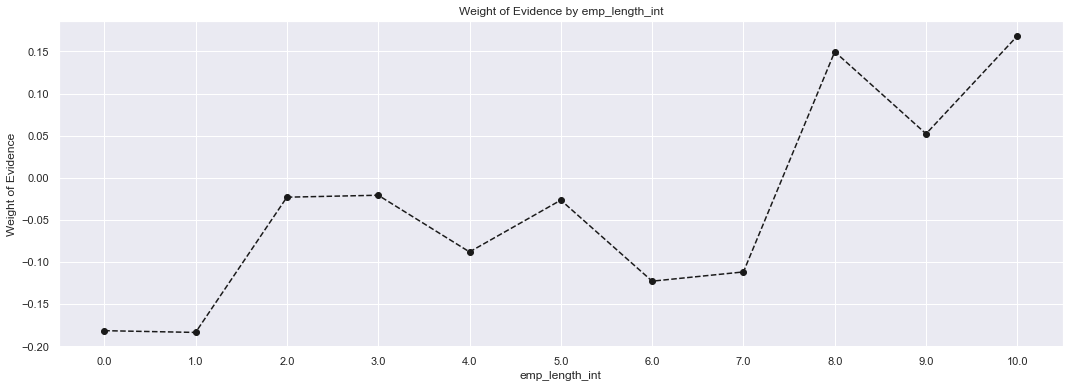

In [78]:
plot_by_woe(df_temp)

In [79]:
# We create the following categories: '0', '1', '2 - 4', '5 - 6', '7 - 9', '10'
# '0' will be the reference category
df_inputs_prepr['emp_length:0'] = \
np.where(df_inputs_prepr['emp_length_int'].isin([0]), 1, 0)
df_inputs_prepr['emp_length:1'] = \
np.where(df_inputs_prepr['emp_length_int'].isin([1]), 1, 0)
df_inputs_prepr['emp_length:2-4'] = \
np.where(df_inputs_prepr['emp_length_int'].isin(range(2, 5)), 1, 0)
df_inputs_prepr['emp_length:5-6'] = \
np.where(df_inputs_prepr['emp_length_int'].isin(range(5, 7)), 1, 0)
df_inputs_prepr['emp_length:7-9'] = \
np.where(df_inputs_prepr['emp_length_int'].isin(range(7, 10)), 1, 0)
df_inputs_prepr['emp_length:10'] = \
np.where(df_inputs_prepr['emp_length_int'].isin([10]), 1, 0)

#### 'mths_since_issue_d'

In [80]:
df_inputs_prepr['mths_since_issue_d'].unique()

array([24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.])

In [81]:
df_inputs_prepr['mths_since_issue_d_factor'] = pd.cut(df_inputs_prepr['mths_since_issue_d'], 50)
df_inputs_prepr['mths_since_issue_d_factor']

0         (23.989, 24.22]
1         (23.989, 24.22]
2         (23.989, 24.22]
3         (23.989, 24.22]
4         (23.989, 24.22]
               ...       
421089      (34.78, 35.0]
421090      (34.78, 35.0]
421091      (34.78, 35.0]
421092      (34.78, 35.0]
421093      (34.78, 35.0]
Name: mths_since_issue_d_factor, Length: 421094, dtype: category
Categories (50, interval[float64]): [(23.989, 24.22] < (24.22, 24.44] < (24.44, 24.66] < (24.66, 24.88] ... (34.12, 34.34] < (34.34, 34.56] < (34.56, 34.78] < (34.78, 35.0]]

In [82]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'mths_since_issue_d_factor', df_targets_prepr)
df_temp.head()

,mths_since_issue_d_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(23.989, 24.22]",44342,1.000000,0.105302,44342.0,0.0,0.107302,0.000000,inf,NaN,NaN,inf
1,"(24.22, 24.44]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
2,"(24.44, 24.66]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
3,"(24.66, 24.88]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
4,"(24.88, 25.1]",37530,0.998082,0.089125,37458.0,72.0,0.090644,0.009171,2.290915,NaN,NaN,inf


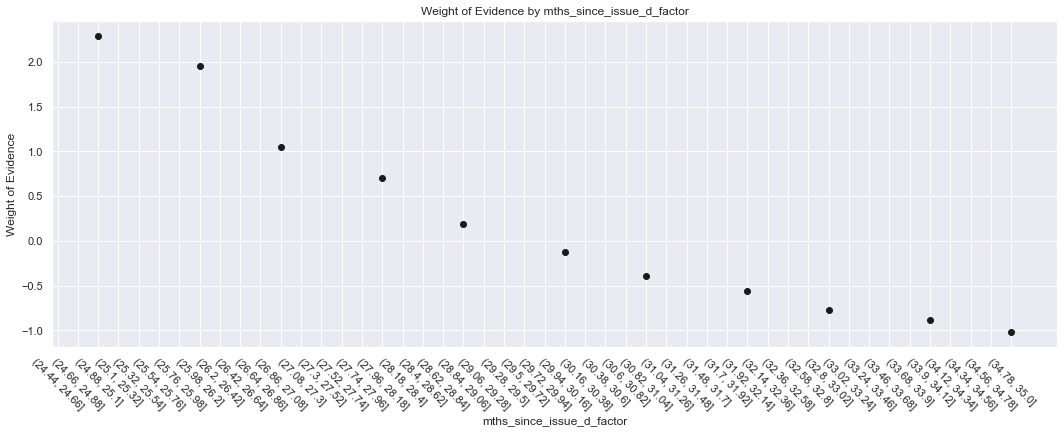

In [83]:
plot_by_woe(df_temp, -45)

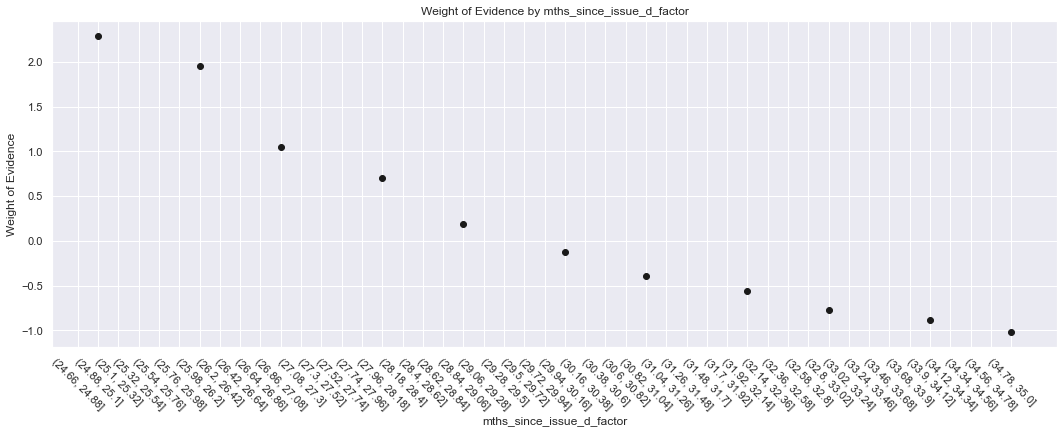

In [84]:
plot_by_woe(df_temp.iloc[3: , : ], -45)

In [85]:
# We create the following categories:
# < 38, 38 - 39, 40 - 41, 42 - 48, 49 - 52, 53 - 64, 65 - 84, > 84.
df_inputs_prepr['mths_since_issue_d:<38'] = \
np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(38)), 1, 0)
df_inputs_prepr['mths_since_issue_d:38-39'] = \
np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(38, 40)), 1, 0)
df_inputs_prepr['mths_since_issue_d:40-41'] = \
np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(40, 42)), 1, 0)
df_inputs_prepr['mths_since_issue_d:42-48'] = \
np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(42, 49)), 1, 0)
df_inputs_prepr['mths_since_issue_d:49-52'] = \
np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(49, 53)), 1, 0)
df_inputs_prepr['mths_since_issue_d:53-64'] = \
np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(53, 65)), 1, 0)
df_inputs_prepr['mths_since_issue_d:65-84'] = \
np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(65, 85)), 1, 0)
df_inputs_prepr['mths_since_issue_d:>84'] = \
np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(85, int(df_inputs_prepr['mths_since_issue_d'].max()))), 1, 0)

#### 'int_rate_factor'

In [86]:
df_inputs_prepr['int_rate_factor'] = pd.cut(df_inputs_prepr['int_rate'], 50)

In [87]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'int_rate_factor', df_targets_prepr)
df_temp.head()

,int_rate_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(5.296, 5.793]",9651,0.999689,0.022919,9648.0,3.0,0.023347,0.000382,4.112499,NaN,NaN,inf
1,"(5.793, 6.267]",10214,0.997259,0.024256,10186.0,28.0,0.024649,0.003566,1.933170,0.002430,2.179329,inf
2,"(6.267, 6.74]",6530,0.994793,0.015507,6496.0,34.0,0.015720,0.004331,1.289186,0.002465,0.643984,inf
3,"(6.74, 7.214]",12488,0.995275,0.029656,12429.0,59.0,0.030077,0.007515,1.386855,0.000482,0.097669,inf
4,"(7.214, 7.687]",11416,0.997985,0.027110,11393.0,23.0,0.027570,0.002930,2.241865,0.002710,0.855010,inf


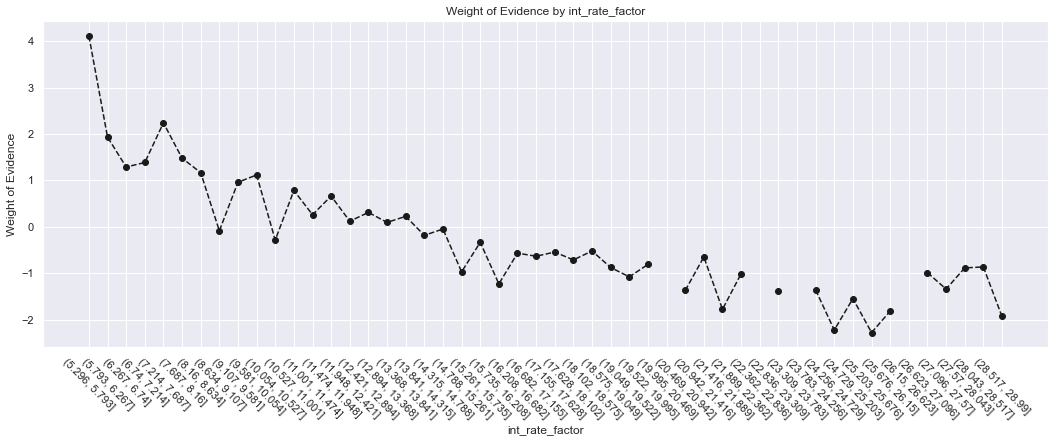

In [88]:
plot_by_woe(df_temp, -45)

In [89]:
# '< 9.548', '9.548 - 12.025', '12.025 - 15.74', '15.74 - 20.281', '> 20.281'
df_inputs_prepr['int_rate:<9.548'] = \
np.where((df_inputs_prepr['int_rate'] <= 9.548), 1, 0)
df_inputs_prepr['int_rate:9.548-12.025'] = \
np.where((df_inputs_prepr['int_rate'] > 9.548) & (df_inputs_prepr['int_rate'] <= 12.025), 1, 0)
df_inputs_prepr['int_rate:12.025-15.74'] = \
np.where((df_inputs_prepr['int_rate'] > 12.025) & (df_inputs_prepr['int_rate'] <= 15.74), 1, 0)
df_inputs_prepr['int_rate:15.74-20.281'] = \
np.where((df_inputs_prepr['int_rate'] > 15.74) & (df_inputs_prepr['int_rate'] <= 20.281), 1, 0)
df_inputs_prepr['int_rate:>20.281'] = \
np.where((df_inputs_prepr['int_rate'] > 20.281), 1, 0)

#### 'funded_amnt'

In [90]:
df_inputs_prepr['funded_amnt_factor'] = pd.cut(df_inputs_prepr['funded_amnt'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr, 'funded_amnt_factor', df_targets_prepr)
df_temp.head()

,funded_amnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(966.0, 1680.0]",3391,0.982306,0.008053,3331.0,60.0,0.008061,0.007642,0.053288,NaN,NaN,0.027107
1,"(1680.0, 2360.0]",3751,0.981338,0.008908,3681.0,70.0,0.008908,0.008916,-0.000950,0.000968,0.054239,0.027107
2,"(2360.0, 3040.0]",8134,0.981190,0.019316,7981.0,153.0,0.019313,0.019488,-0.009014,0.000148,0.008063,0.027107
3,"(3040.0, 3720.0]",5133,0.983246,0.012190,5047.0,86.0,0.012213,0.010954,0.108807,0.002056,0.117821,0.027107
4,"(3720.0, 4400.0]",7315,0.980041,0.017371,7169.0,146.0,0.017348,0.018596,-0.069480,0.003205,0.178287,0.027107


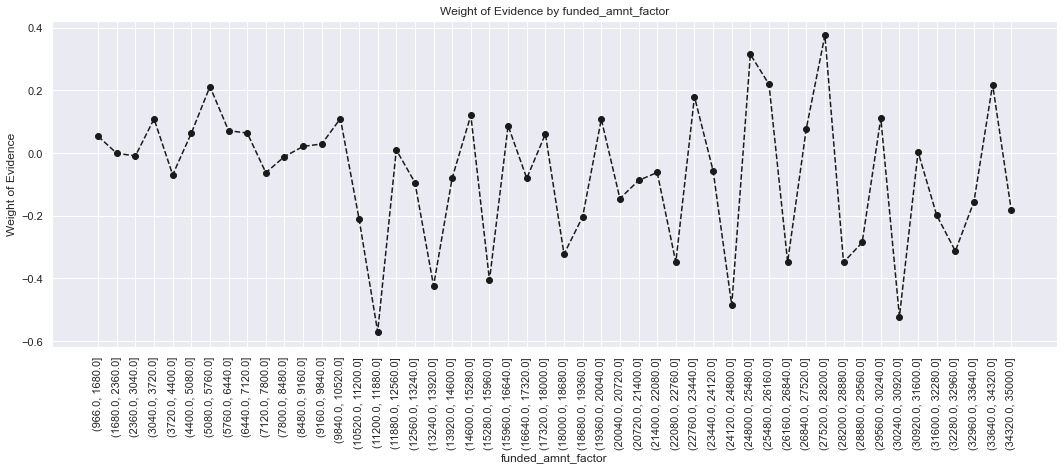

In [91]:
plot_by_woe(df_temp, 90)
# No clear association with this variable -> no need to create dummy variables

#### 'mths_since_earliest_cr_line'

In [92]:
len(df_inputs_prepr['mths_since_earliest_cr_line'].unique())

527

In [93]:
df_inputs_prepr['mths_since_earliest_cr_line_factor'] = \
pd.cut(df_inputs_prepr['mths_since_earliest_cr_line'], 50)
df_inputs_prepr['mths_since_earliest_cr_line_factor']

0          (324.0, 334.52]
1         (187.24, 197.76]
2           (71.52, 82.04]
3          (218.8, 229.32]
4         (197.76, 208.28]
                ...       
421089     (155.68, 166.2]
421090     (523.88, 534.4]
421091     (166.2, 176.72]
421092     (166.2, 176.72]
421093    (187.24, 197.76]
Name: mths_since_earliest_cr_line_factor, Length: 421094, dtype: category
Categories (50, interval[float64]): [(60.474, 71.52] < (71.52, 82.04] < (82.04, 92.56] < (92.56, 103.08] ... (544.92, 555.44] < (555.44, 565.96] < (565.96, 576.48] < (576.48, 587.0]]

In [94]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'mths_since_earliest_cr_line_factor', df_targets_prepr)
df_temp.head()

,mths_since_earliest_cr_line_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(60.474, 71.52]",2001,0.984508,0.004752,1970.0,31.0,0.004767,0.003949,0.188407,NaN,NaN,0.040048
1,"(71.52, 82.04]",4886,0.974417,0.011603,4761.0,125.0,0.011521,0.015922,-0.323496,0.010091,0.511902,0.040048
2,"(82.04, 92.56]",4610,0.972017,0.010948,4481.0,129.0,0.010843,0.016431,-0.415606,0.002399,0.092110,0.040048
3,"(92.56, 103.08]",5446,0.975762,0.012933,5314.0,132.0,0.012859,0.016813,-0.268097,0.003745,0.147509,0.040048
4,"(103.08, 113.6]",6146,0.968272,0.014595,5951.0,195.0,0.014401,0.024838,-0.545080,0.007490,0.276983,0.040048


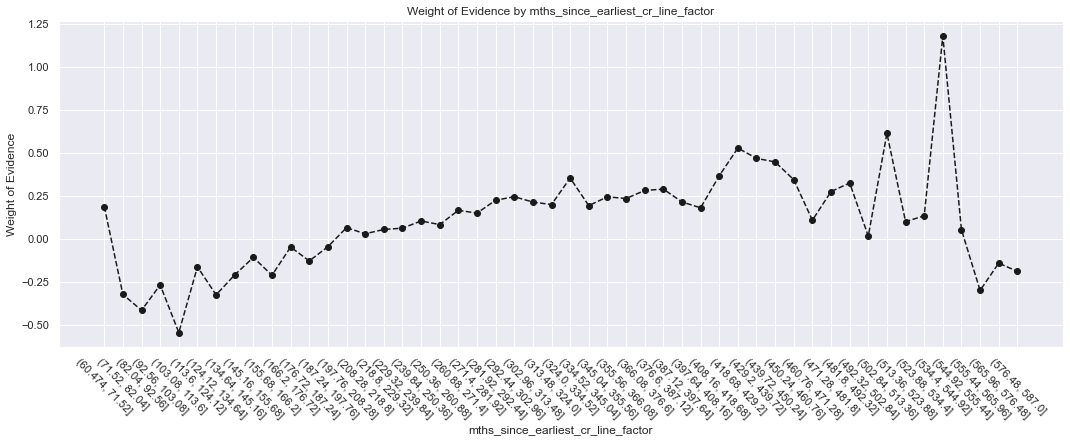

In [95]:
plot_by_woe(df_temp, -45)

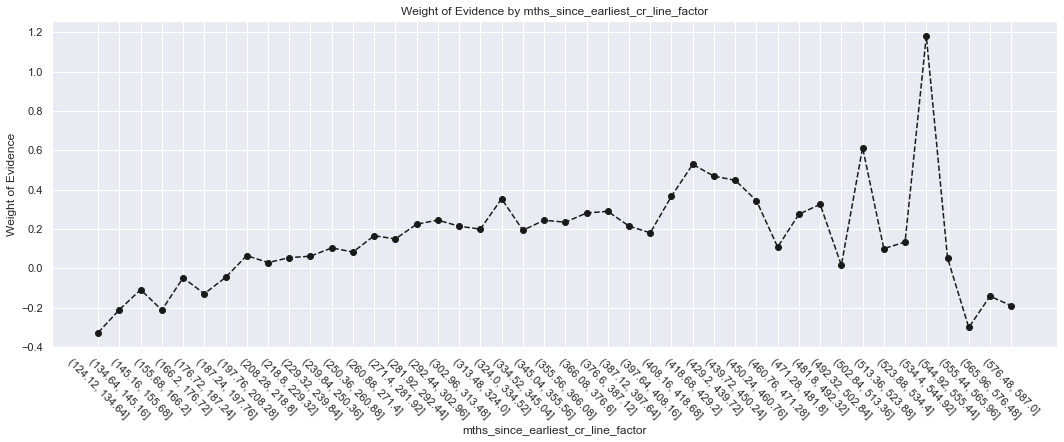

In [96]:
plot_by_woe(df_temp.iloc[6: , : ], -45)

In [97]:
# < 140, # 141 - 164, # 165 - 247, # 248 - 270, # 271 - 352, # > 352
df_inputs_prepr['mths_since_earliest_cr_line:<140'] = \
np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(140)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:141-164'] = \
np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(140, 165)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:165-247'] = \
np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(165, 248)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:248-270'] = \
np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(248, 271)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:271-352'] = \
np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(271, 353)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:>352'] = \
np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(353, int(df_inputs_prepr['mths_since_earliest_cr_line'].max()))), 1, 0)

#### 'installment'

In [98]:
len(df_inputs_prepr['installment'].unique())

40447

In [99]:
df_inputs_prepr['installment_factor'] = \
pd.cut(df_inputs_prepr['installment'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr, 'installment_factor', df_targets_prepr)
df_temp.head()

,installment_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(28.705, 58.427]",3506,0.982886,0.008326,3446.0,60.0,0.008339,0.007642,0.087230,NaN,NaN,inf
1,"(58.427, 86.734]",5832,0.981310,0.013850,5723.0,109.0,0.013849,0.013884,-0.002494,0.001576,0.089724,inf
2,"(86.734, 115.04]",8123,0.983134,0.019290,7986.0,137.0,0.019325,0.017450,0.102069,0.001824,0.104564,inf
3,"(115.04, 143.347]",9139,0.982383,0.021703,8978.0,161.0,0.021726,0.020507,0.057733,0.000751,0.044336,inf
4,"(143.347, 171.654]",17953,0.984459,0.042634,17674.0,279.0,0.042769,0.035537,0.185243,0.002076,0.127510,inf


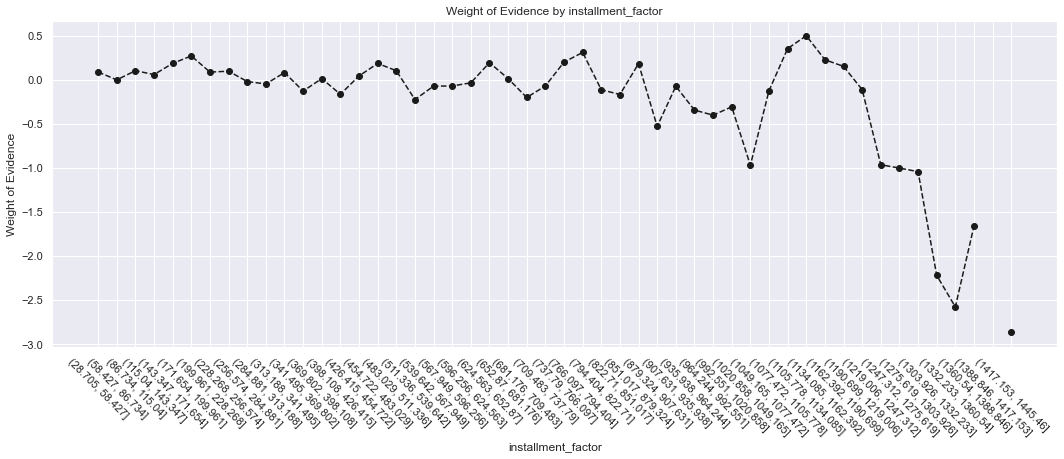

In [100]:
plot_by_woe(df_temp, -45)

#### 'delinq_2yrs'

In [101]:
len(df_inputs_prepr['delinq_2yrs'].unique())

26

In [102]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'delinq_2yrs', df_targets_prepr)
df_temp.head()

E:\Anaconda3\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,delinq_2yrs,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,334007,0.981812,0.793189,327932.0,6075.0,0.793557,0.773787,0.025229,NaN,NaN,inf
1,1.0,57000,0.980246,0.135362,55874.0,1126.0,0.135209,0.143421,-0.058967,0.001566,0.084197,inf
2,2.0,17241,0.979120,0.040943,16881.0,360.0,0.040850,0.045854,-0.115555,0.001126,0.056588,inf
3,3.0,6293,0.976800,0.014944,6147.0,146.0,0.014875,0.018596,-0.223282,0.002320,0.107727,inf
4,4.0,2949,0.976263,0.007003,2879.0,70.0,0.006967,0.008916,-0.246692,0.000536,0.023410,inf


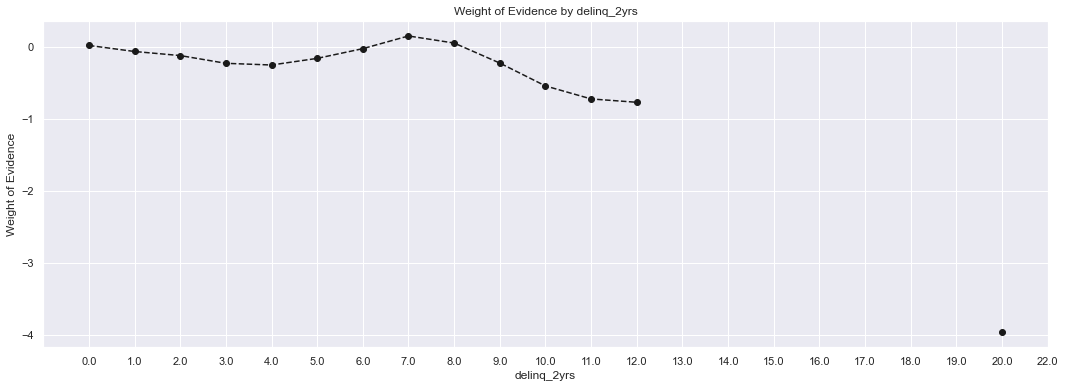

In [103]:
plot_by_woe(df_temp)

In [104]:
# Categories: 0, 1-3, >=4
df_inputs_prepr['delinq_2yrs:0'] = \
np.where((df_inputs_prepr['delinq_2yrs'] == 0), 1, 0)
df_inputs_prepr['delinq_2yrs:1-3'] = \
np.where((df_inputs_prepr['delinq_2yrs'] >= 1) & (df_inputs_prepr['delinq_2yrs'] <= 3), 1, 0)
df_inputs_prepr['delinq_2yrs:>=4'] = \
np.where((df_inputs_prepr['delinq_2yrs'] >= 9), 1, 0)

#### 'inq_last_6mths'

In [105]:
len(df_inputs_prepr['inq_last_6mths'].unique())

7

In [106]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'inq_last_6mths', df_targets_prepr)
df_temp.head()

,inq_last_6mths,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,256407,0.984813,0.608907,252513.0,3894.0,0.611052,0.495988,0.208631,NaN,NaN,0.06837
1,1.0,111346,0.978571,0.264421,108960.0,2386.0,0.263671,0.303910,-0.142032,0.006242,0.350663,0.06837
2,2.0,36292,0.973438,0.086185,35328.0,964.0,0.085490,0.122787,-0.362055,0.005134,0.220023,0.06837
3,3.0,12272,0.964635,0.029143,11838.0,434.0,0.028647,0.055280,-0.657369,0.008803,0.295314,0.06837
4,4.0,3517,0.966164,0.008352,3398.0,119.0,0.008223,0.015157,-0.611576,0.001529,0.045793,0.06837


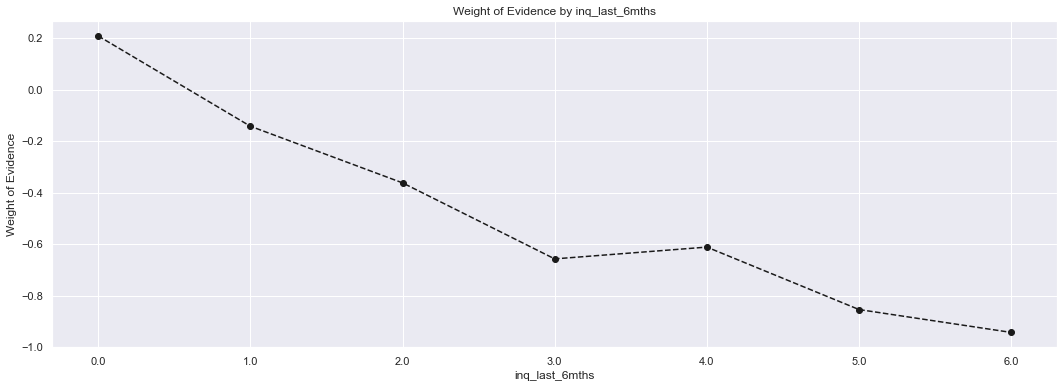

In [107]:
plot_by_woe(df_temp)

In [108]:
# Categories: 0, 1 - 2, 3 - 6, > 6
df_inputs_prepr['inq_last_6mths:0'] = \
np.where((df_inputs_prepr['inq_last_6mths'] == 0), 1, 0)
df_inputs_prepr['inq_last_6mths:1-2'] = \
np.where((df_inputs_prepr['inq_last_6mths'] >= 1) & (df_inputs_prepr['inq_last_6mths'] <= 2), 1, 0)
df_inputs_prepr['inq_last_6mths:3-6'] = \
np.where((df_inputs_prepr['inq_last_6mths'] >= 3) & (df_inputs_prepr['inq_last_6mths'] <= 6), 1, 0)
df_inputs_prepr['inq_last_6mths:>6'] = \
np.where((df_inputs_prepr['inq_last_6mths'] > 6), 1, 0)

#### 'open_acc'

In [109]:
len(df_inputs_prepr['open_acc'].unique())

73

In [110]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'open_acc', df_targets_prepr)
df_temp.head()

E:\Anaconda3\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,open_acc,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,1.0,90,0.988889,0.000214,89.0,1.0,0.000215,0.000127,0.525241,NaN,NaN,inf
1,2.0,986,0.972617,0.002342,959.0,27.0,0.002321,0.003439,-0.393341,0.016272,0.918582,inf
2,3.0,4119,0.984462,0.009782,4055.0,64.0,0.009813,0.008152,0.185428,0.011846,0.578769,inf
3,4.0,10779,0.978941,0.025598,10552.0,227.0,0.025535,0.028914,-0.124274,0.005522,0.309702,inf
4,5.0,18222,0.980738,0.043273,17871.0,351.0,0.043246,0.044708,-0.033247,0.001797,0.091028,inf


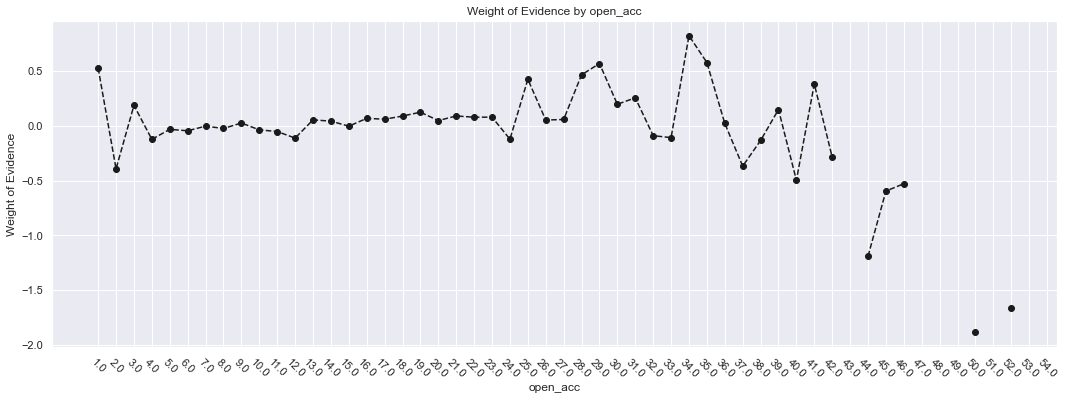

In [111]:
plot_by_woe(df_temp, -45)

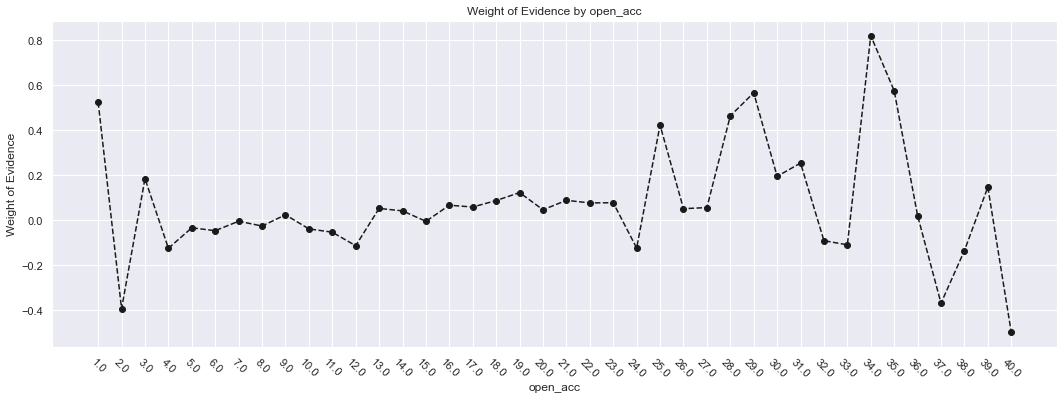

In [112]:
plot_by_woe(df_temp.iloc[ : 40, :], -45)

In [113]:
# Categories: '0', '1-3', '4-12', '13-17', '18-22', '23-25', '26-30', '>30'
df_inputs_prepr['open_acc:0'] = \
np.where((df_inputs_prepr['open_acc'] == 0), 1, 0)
df_inputs_prepr['open_acc:1-3'] = \
np.where((df_inputs_prepr['open_acc'] >= 1) & (df_inputs_prepr['open_acc'] <= 3), 1, 0)
df_inputs_prepr['open_acc:4-12'] = \
np.where((df_inputs_prepr['open_acc'] >= 4) & (df_inputs_prepr['open_acc'] <= 12), 1, 0)
df_inputs_prepr['open_acc:13-17'] = \
np.where((df_inputs_prepr['open_acc'] >= 13) & (df_inputs_prepr['open_acc'] <= 17), 1, 0)
df_inputs_prepr['open_acc:18-22'] = \
np.where((df_inputs_prepr['open_acc'] >= 18) & (df_inputs_prepr['open_acc'] <= 22), 1, 0)
df_inputs_prepr['open_acc:23-25'] = \
np.where((df_inputs_prepr['open_acc'] >= 23) & (df_inputs_prepr['open_acc'] <= 25), 1, 0)
df_inputs_prepr['open_acc:26-30'] = \
np.where((df_inputs_prepr['open_acc'] >= 26) & (df_inputs_prepr['open_acc'] <= 30), 1, 0)
df_inputs_prepr['open_acc:>=31'] = \
np.where((df_inputs_prepr['open_acc'] >= 31), 1, 0)

#### 'pub_rec'

In [114]:
len(df_inputs_prepr['pub_rec'].unique())

28

In [115]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'pub_rec', df_targets_prepr)
df_temp.head()

E:\Anaconda3\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,pub_rec,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,346679,0.981594,0.823282,340298.0,6381.0,0.823482,0.812763,0.013102,NaN,NaN,inf
1,1.0,60215,0.979972,0.142997,59009.0,1206.0,0.142795,0.153611,-0.073014,0.001622,0.086116,inf
2,2.0,9230,0.982124,0.021919,9065.0,165.0,0.021936,0.021016,0.042836,0.002152,0.115850,inf
3,3.0,2876,0.979833,0.006830,2818.0,58.0,0.006819,0.007388,-0.080055,0.002290,0.122891,inf
4,4.0,1044,0.977011,0.002479,1020.0,24.0,0.002468,0.003057,-0.213891,0.002822,0.133836,inf


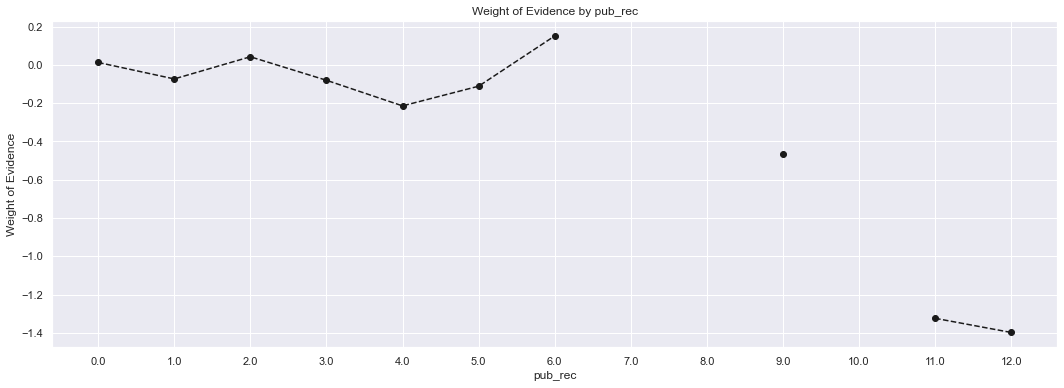

In [116]:
plot_by_woe(df_temp)

In [117]:
# Categories '0-2', '3-4', '>=5'
df_inputs_prepr['pub_rec:0-2'] = \
np.where((df_inputs_prepr['pub_rec'] >= 0) & (df_inputs_prepr['pub_rec'] <= 2), 1, 0)
df_inputs_prepr['pub_rec:3-4'] = \
np.where((df_inputs_prepr['pub_rec'] >= 3) & (df_inputs_prepr['pub_rec'] <= 4), 1, 0)
df_inputs_prepr['pub_rec:>=5'] = \
np.where((df_inputs_prepr['pub_rec'] >= 5), 1, 0)

#### 'total_acc'

In [118]:
len(df_inputs_prepr['total_acc'].unique())

126

In [119]:
df_inputs_prepr['total_acc_factor'] = pd.cut(df_inputs_prepr['total_acc'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr, 'total_acc_factor', df_targets_prepr)
df_temp.head()

E:\Anaconda3\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,total_acc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(3.835, 7.3]",11333,0.976970,0.026913,11072.0,261.0,0.026793,0.033244,-0.215741,NaN,NaN,inf
1,"(7.3, 10.6]",21005,0.979767,0.049882,20580.0,425.0,0.049801,0.054133,-0.083409,0.002797,0.132332,inf
2,"(10.6, 13.9]",31446,0.979457,0.074677,30800.0,646.0,0.074532,0.082283,-0.098924,0.000310,0.015515,inf
3,"(13.9, 17.2]",53180,0.980557,0.126290,52146.0,1034.0,0.126187,0.131703,-0.042782,0.001100,0.056142,inf
4,"(17.2, 20.5]",44528,0.981742,0.105744,43715.0,813.0,0.105785,0.103554,0.021321,0.001185,0.064103,inf


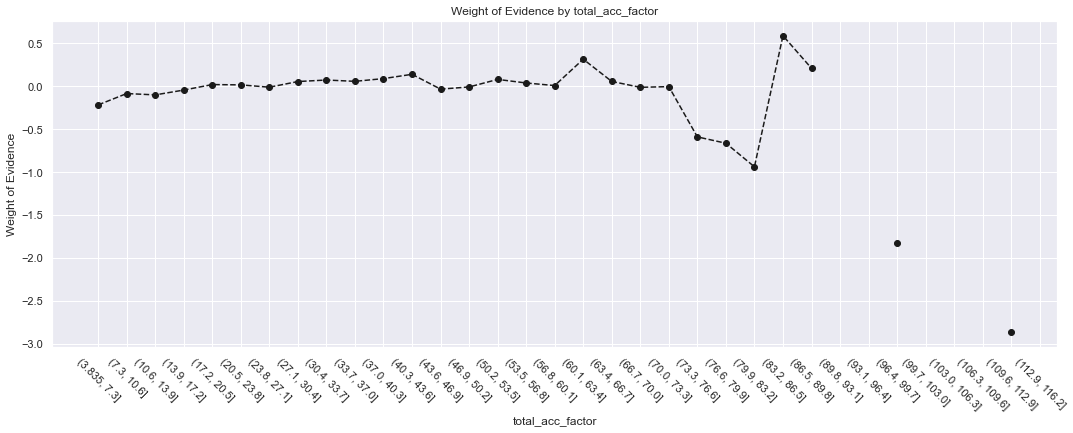

In [120]:
plot_by_woe(df_temp, -45)

In [121]:
# Categories: '<=27', '28-51', '>51'
df_inputs_prepr['total_acc:<=27'] = \
np.where((df_inputs_prepr['total_acc'] <= 27), 1, 0)
df_inputs_prepr['total_acc:28-51'] = \
np.where((df_inputs_prepr['total_acc'] >= 28) & (df_inputs_prepr['total_acc'] <= 51), 1, 0)
df_inputs_prepr['total_acc:>=52'] = \
np.where((df_inputs_prepr['total_acc'] >= 52), 1, 0)

#### 'acc_now_delinq'

In [122]:
len(df_inputs_prepr['acc_now_delinq'].unique())

8

In [123]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'acc_now_delinq', df_targets_prepr)
df_temp

E:\Anaconda3\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,acc_now_delinq,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,418712,0.981424,0.994343,410934.0,7778.0,0.994412,0.990702,0.003738,NaN,NaN,inf
1,1.0,2243,0.971021,0.005327,2178.0,65.0,0.005271,0.008279,-0.451620,0.010403,0.455358,inf
2,2.0,116,0.939655,0.000275,109.0,7.0,0.000264,0.000892,-1.217957,0.031366,0.766337,inf
3,3.0,17,1.000000,0.000040,17.0,0.0,0.000041,0.000000,inf,0.060345,inf,inf
4,4.0,3,0.666667,0.000007,2.0,1.0,0.000005,0.000127,-3.270248,0.333333,inf,inf
5,5.0,1,1.000000,0.000002,1.0,0.0,0.000002,0.000000,inf,0.333333,inf,inf
6,6.0,1,1.000000,0.000002,1.0,0.0,0.000002,0.000000,inf,0.000000,NaN,inf
7,14.0,1,1.000000,0.000002,1.0,0.0,0.000002,0.000000,inf,0.000000,NaN,inf


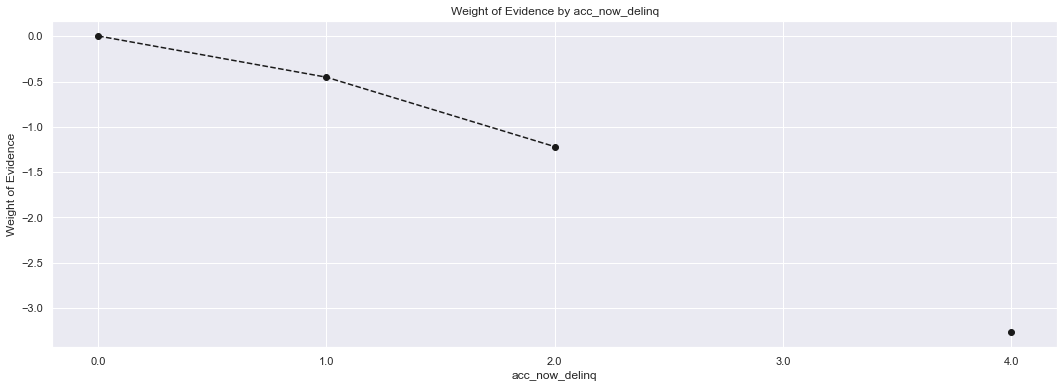

In [124]:
plot_by_woe(df_temp)

In [125]:
# Categories: '0', '>=1'
df_inputs_prepr['acc_now_delinq:0'] = \
np.where((df_inputs_prepr['acc_now_delinq'] == 0), 1, 0)
df_inputs_prepr['acc_now_delinq:>=1'] = \
np.where((df_inputs_prepr['acc_now_delinq'] >= 1), 1, 0)

#### 'total_rev_hi_lim'

In [126]:
len(df_inputs_prepr['total_rev_hi_lim'].unique())

10694

In [127]:
df_inputs_prepr['total_rev_hi_lim_factor'] = pd.cut(df_inputs_prepr['total_rev_hi_lim'], 2000)
df_temp = woe_ordered_continuous(df_inputs_prepr, 'total_rev_hi_lim_factor', df_targets_prepr)
df_temp

E:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\Anaconda3\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,total_rev_hi_lim_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-9999.999, 5000.0]",12981,0.971266,0.030827,12608.0,373.0,0.030510,0.047510,-0.442886,NaN,NaN,inf
1,"(5000.0, 9999.999]",42858,0.974801,0.101778,41778.0,1080.0,0.101098,0.137562,-0.307986,0.003535,0.134900,inf
2,"(9999.999, 14999.998]",56173,0.977658,0.133398,54918.0,1255.0,0.132895,0.159852,-0.184689,0.002858,0.123297,inf
3,"(14999.998, 19999.998]",54873,0.979498,0.130311,53748.0,1125.0,0.130064,0.143294,-0.096871,0.001840,0.087818,inf
4,"(19999.998, 24999.997]",46739,0.981942,0.110994,45895.0,844.0,0.111061,0.107502,0.032564,0.002444,0.129436,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,"(9974999.002, 9979999.002]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1996,"(9979999.002, 9984999.002]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1997,"(9984999.002, 9989999.001]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1998,"(9989999.001, 9994999.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


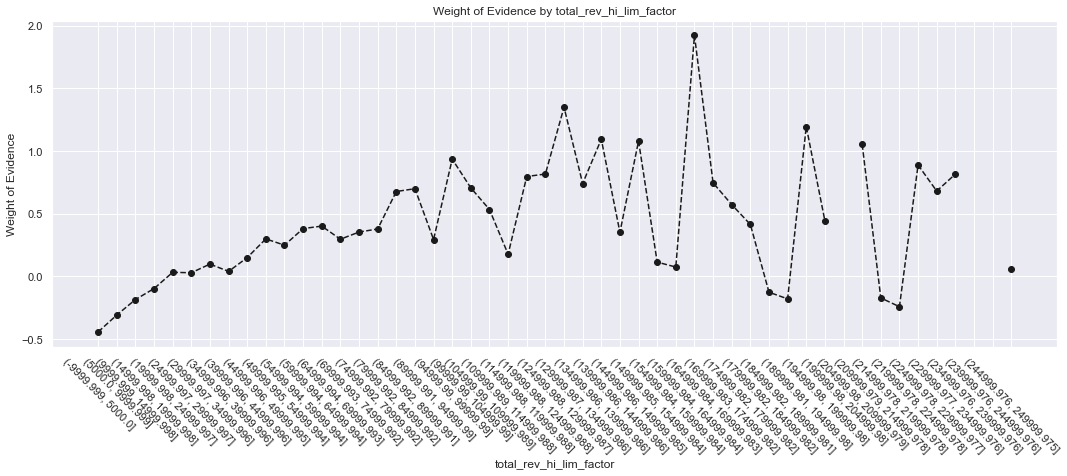

In [128]:
plot_by_woe(df_temp.iloc[: 50, : ], -45)

In [129]:
# Categories
# '<=5K', '5K-10K', '10K-20K', '20K-30K', '30K-40K', '40K-55K', '55K-95K', '>95K'
df_inputs_prepr['total_rev_hi_lim:<=5K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] <= 5000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:5K-10K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 5000) & (df_inputs_prepr['total_rev_hi_lim'] <= 10000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:10K-20K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 10000) & (df_inputs_prepr['total_rev_hi_lim'] <= 20000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:20K-30K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 20000) & (df_inputs_prepr['total_rev_hi_lim'] <= 30000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:30K-40K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 30000) & (df_inputs_prepr['total_rev_hi_lim'] <= 40000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:40K-55K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 40000) & (df_inputs_prepr['total_rev_hi_lim'] <= 55000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:55K-95K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 55000) & (df_inputs_prepr['total_rev_hi_lim'] <= 95000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:>95K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 95000), 1, 0)

#### 'annual_inc'

In [130]:
len(df_inputs_prepr['annual_inc'].unique())

26903

In [131]:
df_inputs_prepr['annual_inc_factor'] = pd.cut(df_inputs_prepr['annual_inc'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr, 'annual_inc_factor', df_targets_prepr)
df_temp.head()
# Note: propotion of good obs of 1st class is 94% -> too high!

E:\Anaconda3\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-9500.0, 190000.0]",409693,0.981193,0.972925,401988.0,7705.0,0.972764,0.981404,-0.008842,NaN,NaN,inf
1,"(190000.0, 380000.0]",10007,0.986609,0.023764,9873.0,134.0,0.023892,0.017068,0.336324,0.005416,0.345166,inf
2,"(380000.0, 570000.0]",943,0.990456,0.002239,934.0,9.0,0.002260,0.001146,0.678857,0.003847,0.342533,inf
3,"(570000.0, 760000.0]",257,1.000000,0.000610,257.0,0.0,0.000622,0.000000,inf,0.009544,inf,inf
4,"(760000.0, 950000.0]",70,1.000000,0.000166,70.0,0.0,0.000169,0.000000,inf,0.000000,NaN,inf


In [132]:
df_inputs_prepr['annual_inc_factor'] = pd.cut(df_inputs_prepr['annual_inc'], 100)
df_temp = woe_ordered_continuous(df_inputs_prepr, 'annual_inc_factor', df_targets_prepr)
df_temp.head()
# Still, the proportion of first 2 classes together is too high!

E:\Anaconda3\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-9500.0, 95000.0]",325648,0.980203,0.773338,319201.0,6447.0,0.772429,0.821169,-0.061189,NaN,NaN,inf
1,"(95000.0, 190000.0]",84045,0.985032,0.199587,82787.0,1258.0,0.200335,0.160234,0.223353,0.004829,0.284542,inf
2,"(190000.0, 285000.0]",8186,0.986196,0.019440,8073.0,113.0,0.019536,0.014393,0.305498,0.001164,0.082145,inf
3,"(285000.0, 380000.0]",1821,0.988468,0.004324,1800.0,21.0,0.004356,0.002675,0.487625,0.002272,0.182127,inf
4,"(380000.0, 475000.0]",652,0.990798,0.001548,646.0,6.0,0.001563,0.000764,0.715645,0.002330,0.228021,inf


In [133]:
# To determine the categories of everyone with 140k or less.
df_inputs_prepr_temp = \
df_inputs_prepr.loc[df_inputs_prepr['annual_inc'] <= 140000, : ]

In [134]:
df_inputs_prepr_temp["annual_inc_factor"] = pd.cut(df_inputs_prepr_temp['annual_inc'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'annual_inc_factor', df_targets_prepr[df_inputs_prepr_temp.index])
df_temp

<ipython-input-134-adc82fd2d3fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp["annual_inc_factor"] = pd.cut(df_inputs_prepr_temp['annual_inc'], 50)


,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-140.0, 2800.0]",4,1.000000,0.000010,4.0,0.0,0.000010,0.000000,inf,NaN,NaN,inf
1,"(2800.0, 5600.0]",12,0.916667,0.000031,11.0,1.0,0.000029,0.000135,-1.547375,0.083333,inf,inf
2,"(5600.0, 8400.0]",55,0.981818,0.000141,54.0,1.0,0.000141,0.000135,0.043714,0.065152,1.591089,inf
3,"(8400.0, 11200.0]",429,0.965035,0.001097,414.0,15.0,0.001079,0.002022,-0.627454,0.016783,0.671168,inf
4,"(11200.0, 14000.0]",873,0.977090,0.002233,853.0,20.0,0.002224,0.002695,-0.192243,0.012056,0.435212,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
45,"(126000.0, 128800.0]",981,0.982671,0.002509,964.0,17.0,0.002513,0.002291,0.092608,0.001193,0.072559,inf
46,"(128800.0, 131600.0]",3885,0.987902,0.009937,3838.0,47.0,0.010007,0.006334,0.457289,0.005231,0.364681,inf
47,"(131600.0, 134400.0]",971,0.992791,0.002484,964.0,7.0,0.002513,0.000943,0.979911,0.004889,0.522622,inf
48,"(134400.0, 137200.0]",2552,0.984326,0.006527,2512.0,40.0,0.006549,0.005391,0.194685,0.008465,0.785226,inf


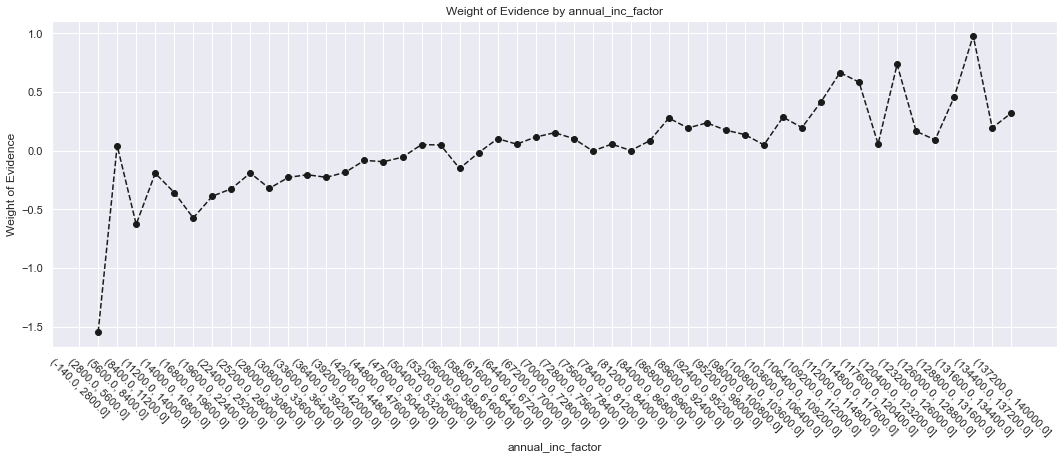

In [135]:
plot_by_woe(df_temp, -45)

In [136]:
# WoE is monotonically decreasing with income, 
#  so we split income in 10 equal categories, each with width of 15k.
df_inputs_prepr['annual_inc:<20K'] = np.where((df_inputs_prepr['annual_inc'] <= 20000), 1, 0)
df_inputs_prepr['annual_inc:20K-30K'] = np.where((df_inputs_prepr['annual_inc'] > 20000) & (df_inputs_prepr['annual_inc'] <= 30000), 1, 0)
df_inputs_prepr['annual_inc:30K-40K'] = np.where((df_inputs_prepr['annual_inc'] > 30000) & (df_inputs_prepr['annual_inc'] <= 40000), 1, 0)
df_inputs_prepr['annual_inc:40K-50K'] = np.where((df_inputs_prepr['annual_inc'] > 40000) & (df_inputs_prepr['annual_inc'] <= 50000), 1, 0)
df_inputs_prepr['annual_inc:50K-60K'] = np.where((df_inputs_prepr['annual_inc'] > 50000) & (df_inputs_prepr['annual_inc'] <= 60000), 1, 0)
df_inputs_prepr['annual_inc:60K-70K'] = np.where((df_inputs_prepr['annual_inc'] > 60000) & (df_inputs_prepr['annual_inc'] <= 70000), 1, 0)
df_inputs_prepr['annual_inc:70K-80K'] = np.where((df_inputs_prepr['annual_inc'] > 70000) & (df_inputs_prepr['annual_inc'] <= 80000), 1, 0)
df_inputs_prepr['annual_inc:80K-90K'] = np.where((df_inputs_prepr['annual_inc'] > 80000) & (df_inputs_prepr['annual_inc'] <= 90000), 1, 0)
df_inputs_prepr['annual_inc:90K-100K'] = np.where((df_inputs_prepr['annual_inc'] > 90000) & (df_inputs_prepr['annual_inc'] <= 100000), 1, 0)
df_inputs_prepr['annual_inc:100K-120K'] = np.where((df_inputs_prepr['annual_inc'] > 100000) & (df_inputs_prepr['annual_inc'] <= 120000), 1, 0)
df_inputs_prepr['annual_inc:120K-140K'] = np.where((df_inputs_prepr['annual_inc'] > 120000) & (df_inputs_prepr['annual_inc'] <= 140000), 1, 0)
df_inputs_prepr['annual_inc:>140K'] = np.where((df_inputs_prepr['annual_inc'] > 140000), 1, 0)

#### 'mths_since_last_delinq'

In [137]:
len(df_inputs_prepr['mths_since_last_delinq'].unique())

141

In [138]:
# Since 'mths_since_last_delinq' has missing values
# We have to create one category for missing values 
#  and do fine and coarse classing for the rest.
df_inputs_prepr_temp = \
df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_delinq'])]

In [139]:
df_inputs_prepr_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_delinq'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'mths_since_last_delinq_factor', df_targets_prepr[df_inputs_prepr_temp.index])
df_temp.head()

<ipython-input-139-b3da0623867a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_delinq'], 50)
E:\Anaconda3\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,mths_since_last_delinq_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.176, 3.52]",7261,0.973833,0.033440,7071.0,190.0,0.033183,0.047041,-0.349003,NaN,NaN,inf
1,"(3.52, 7.04]",15763,0.978367,0.072596,15422.0,341.0,0.072372,0.084427,-0.154068,0.004534,0.194935,inf
2,"(7.04, 10.56]",12365,0.980348,0.056947,12122.0,243.0,0.056886,0.060163,-0.056020,0.001981,0.098048,inf
3,"(10.56, 14.08]",16125,0.979721,0.074263,15798.0,327.0,0.074136,0.080961,-0.088058,0.000627,0.032037,inf
4,"(14.08, 17.6]",11384,0.976985,0.052429,11122.0,262.0,0.052193,0.064868,-0.217400,0.002736,0.129343,inf


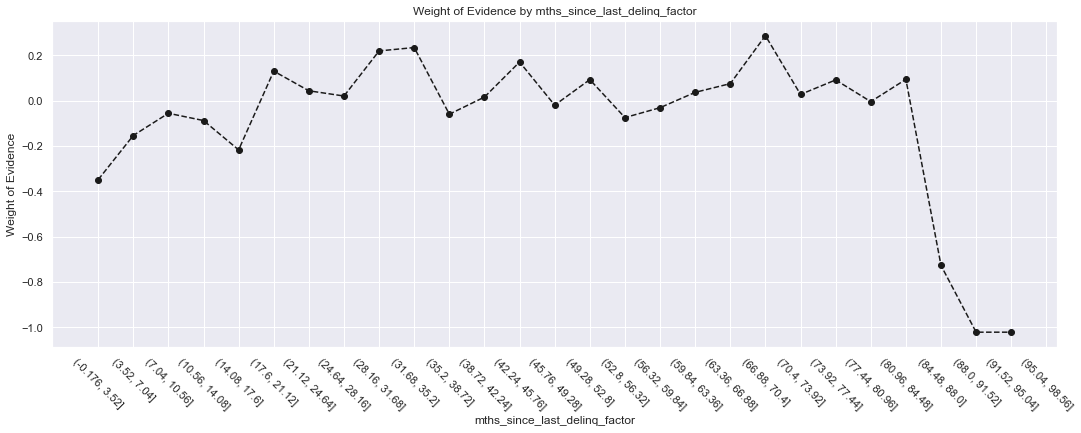

In [140]:
plot_by_woe(df_temp, -45)

In [141]:
# Categories: Missing, 0-3, 4-30, 31-56, >=57
df_inputs_prepr['mths_since_last_delinq:Missing'] = np.where((df_inputs_prepr['mths_since_last_delinq'].isnull()), 1, 0)
df_inputs_prepr['mths_since_last_delinq:0-3'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 0) & (df_inputs_prepr['mths_since_last_delinq'] <= 3), 1, 0)
df_inputs_prepr['mths_since_last_delinq:4-30'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 4) & (df_inputs_prepr['mths_since_last_delinq'] <= 30), 1, 0)
df_inputs_prepr['mths_since_last_delinq:31-56'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 31) & (df_inputs_prepr['mths_since_last_delinq'] <= 56), 1, 0)
df_inputs_prepr['mths_since_last_delinq:>=57'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 57), 1, 0)

#### 'dti'

In [142]:
len(df_inputs_prepr['dti'].unique())

4086

In [143]:
df_inputs_prepr['dti_factor'] = pd.cut(df_inputs_prepr['dti'], 100)
df_temp = woe_ordered_continuous(df_inputs_prepr, 'dti_factor', df_targets_prepr)
df_temp

,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-9.999, 99.99]",421083,0.981355,0.999974,413232.0,7851.0,0.999973,1.0,-0.000027,NaN,NaN,inf
1,"(99.99, 199.98]",6,1.000000,0.000014,6.0,0.0,0.000015,0.0,inf,0.018645,inf,inf
2,"(199.98, 299.97]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
3,"(299.97, 399.96]",1,1.000000,0.000002,1.0,0.0,0.000002,0.0,inf,NaN,NaN,inf
4,"(399.96, 499.95]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
95,"(9499.05, 9599.04]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
96,"(9599.04, 9699.03]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
97,"(9699.03, 9799.02]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
98,"(9799.02, 9899.01]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


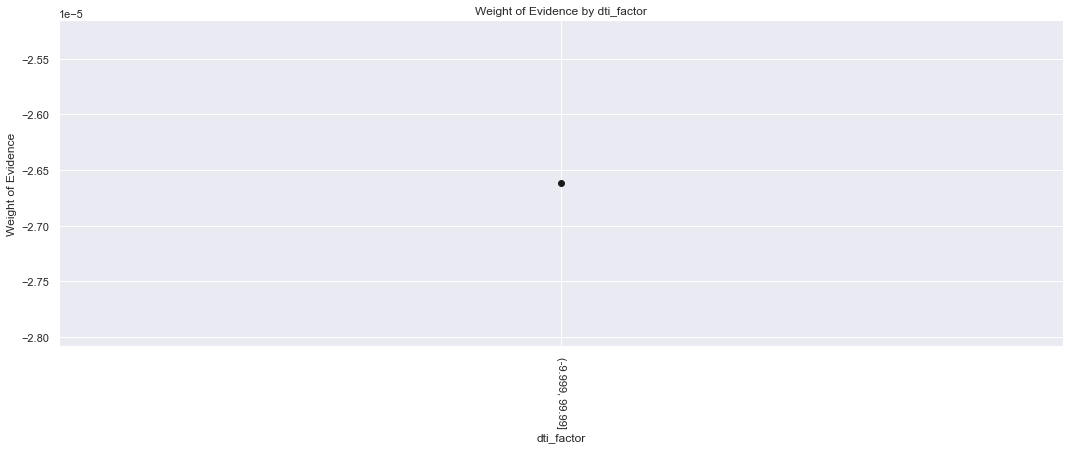

In [144]:
plot_by_woe(df_temp, -90)

In [145]:
# Most values are lower than 200.
#  Have one category for more than 35, 
#  and we are going to apply our approach to determine
#  the categories of everyone with 150k or less.
df_inputs_prepr_temp = df_inputs_prepr.loc[df_inputs_prepr['dti'] <= 35, : ]

In [146]:
df_inputs_prepr_temp['dti_factor'] = pd.cut(df_inputs_prepr_temp['dti'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'dti_factor', df_targets_prepr[df_inputs_prepr_temp.index])
df_temp

<ipython-input-146-1c8a19b137f1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp['dti_factor'] = pd.cut(df_inputs_prepr_temp['dti'], 50)


,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.035, 0.7]",707,0.980198,0.001749,693.0,14.0,0.001746,0.001907,-0.088060,NaN,NaN,0.045535
1,"(0.7, 1.4]",1116,0.977599,0.002761,1091.0,25.0,0.002749,0.003406,-0.214059,0.002599,0.125999,0.045535
2,"(1.4, 2.1]",1596,0.981830,0.003949,1567.0,29.0,0.003949,0.003950,-0.000410,0.004231,0.213648,0.045535
3,"(2.1, 2.8]",2140,0.982710,0.005295,2103.0,37.0,0.005299,0.005040,0.050169,0.000881,0.050580,0.045535
4,"(2.8, 3.5]",2873,0.981552,0.007108,2820.0,53.0,0.007106,0.007220,-0.015833,0.001158,0.066002,0.045535
...,...,...,...,...,...,...,...,...,...,...,...,...
45,"(31.5, 32.2]",5397,0.973319,0.013353,5253.0,144.0,0.013237,0.019616,-0.393292,0.001766,0.070294,0.045535
46,"(32.2, 32.9]",5120,0.970703,0.012668,4970.0,150.0,0.012524,0.020433,-0.489493,0.002615,0.096201,0.045535
47,"(32.9, 33.6]",4618,0.974015,0.011426,4498.0,120.0,0.011335,0.016347,-0.366137,0.003312,0.123357,0.045535
48,"(33.6, 34.3]",4552,0.972540,0.011263,4427.0,125.0,0.011156,0.017028,-0.422869,0.001475,0.056733,0.045535


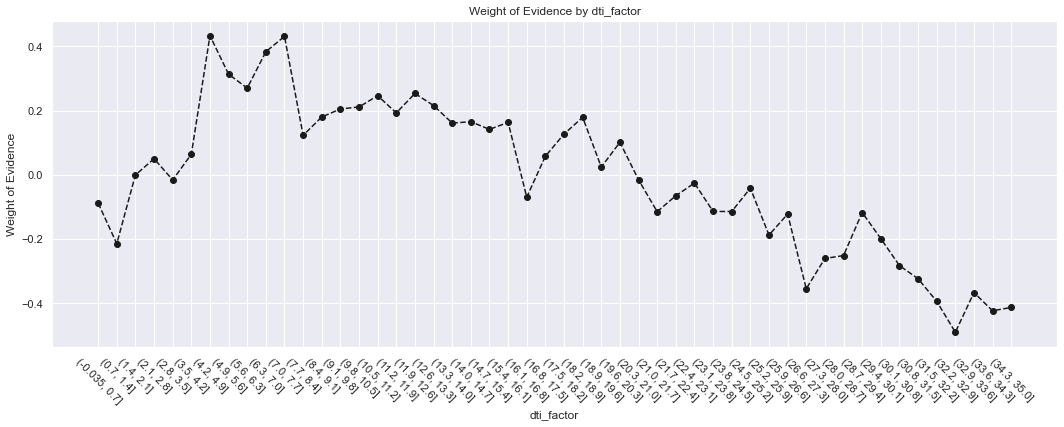

In [147]:
plot_by_woe(df_temp, -45)

In [148]:
# Categories:
df_inputs_prepr['dti:<=1.4'] = np.where((df_inputs_prepr['dti'] <= 1.4), 1, 0)
df_inputs_prepr['dti:1.4-3.5'] = np.where((df_inputs_prepr['dti'] > 1.4) & (df_inputs_prepr['dti'] <= 3.5), 1, 0)
df_inputs_prepr['dti:3.5-7.7'] = np.where((df_inputs_prepr['dti'] > 3.5) & (df_inputs_prepr['dti'] <= 7.7), 1, 0)
df_inputs_prepr['dti:7.7-10.5'] = np.where((df_inputs_prepr['dti'] > 7.7) & (df_inputs_prepr['dti'] <= 10.5), 1, 0)
df_inputs_prepr['dti:10.5-16.1'] = np.where((df_inputs_prepr['dti'] > 10.5) & (df_inputs_prepr['dti'] <= 16.1), 1, 0)
df_inputs_prepr['dti:16.1-20.3'] = np.where((df_inputs_prepr['dti'] > 16.1) & (df_inputs_prepr['dti'] <= 20.3), 1, 0)
df_inputs_prepr['dti:20.3-21.7'] = np.where((df_inputs_prepr['dti'] > 20.3) & (df_inputs_prepr['dti'] <= 21.7), 1, 0)
df_inputs_prepr['dti:21.7-22.4'] = np.where((df_inputs_prepr['dti'] > 21.7) & (df_inputs_prepr['dti'] <= 22.4), 1, 0)
df_inputs_prepr['dti:22.4-35'] = np.where((df_inputs_prepr['dti'] > 22.4) & (df_inputs_prepr['dti'] <= 35), 1, 0)
df_inputs_prepr['dti:>35'] = np.where((df_inputs_prepr['dti'] > 35), 1, 0)

#### 'mths_since_last_record'

In [149]:
len(df_inputs_prepr['mths_since_last_record'].unique())

122

In [150]:
# Handle missing values
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_record'])]

In [151]:
df_inputs_prepr_temp['mths_since_last_record_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_record'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'mths_since_last_record_factor', df_targets_prepr[df_inputs_prepr_temp.index])
df_temp.head()

<ipython-input-151-036f10381db5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp['mths_since_last_record_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_record'], 50)


,mths_since_last_record_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.12, 2.4]",87,0.965517,0.001169,84.0,3.0,0.001152,0.002041,-0.572239,NaN,NaN,0.060687
1,"(2.4, 4.8]",161,0.968944,0.002164,156.0,5.0,0.002139,0.003401,-0.464025,0.003427,0.108214,0.060687
2,"(4.8, 7.2]",344,0.976744,0.004623,336.0,8.0,0.004606,0.005442,-0.166774,0.007800,0.297252,0.060687
3,"(7.2, 9.6]",291,0.982818,0.003911,286.0,5.0,0.003921,0.003401,0.142111,0.006074,0.308884,0.060687
4,"(9.6, 12.0]",537,0.970205,0.007216,521.0,16.0,0.007142,0.010884,-0.421282,0.012613,0.563393,0.060687


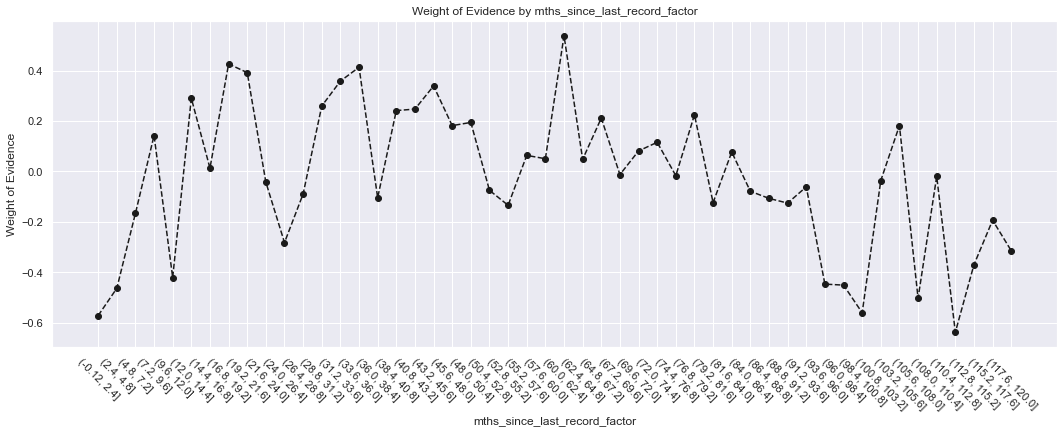

In [152]:
plot_by_woe(df_temp, -45)

In [153]:
# Categories: 'Missing', '0-2', '3-20', '21-31', '32-80', '81-86', '>86'
df_inputs_prepr['mths_since_last_record:Missing'] = np.where((df_inputs_prepr['mths_since_last_record'].isnull()), 1, 0)
df_inputs_prepr['mths_since_last_record:0-2'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 0) & (df_inputs_prepr['mths_since_last_record'] <= 2), 1, 0)
df_inputs_prepr['mths_since_last_record:3-20'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 3) & (df_inputs_prepr['mths_since_last_record'] <= 20), 1, 0)
df_inputs_prepr['mths_since_last_record:21-31'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 21) & (df_inputs_prepr['mths_since_last_record'] <= 31), 1, 0)
df_inputs_prepr['mths_since_last_record:32-80'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 32) & (df_inputs_prepr['mths_since_last_record'] <= 80), 1, 0)
df_inputs_prepr['mths_since_last_record:81-86'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 81) & (df_inputs_prepr['mths_since_last_record'] <= 86), 1, 0)
df_inputs_prepr['mths_since_last_record:>86'] = np.where((df_inputs_prepr['mths_since_last_record'] > 86), 1, 0)

In [154]:
#####
#loan_data_inputs_train = df_inputs_prepr
#####
#loan_data_inputs_test = df_inputs_prepr

In [155]:
loan_data_inputs_2015 = df_inputs_prepr
loan_data_targets_2015 = df_targets_prepr

In [156]:
#loan_data_inputs_train.to_csv('loan_data_inputs_train.csv')
#loan_data_targets_train.to_csv('loan_data_targets_train.csv')
#loan_data_inputs_test.to_csv('loan_data_inputs_test.csv')
#loan_data_targets_test.to_csv('loan_data_targets_test.csv')

In [157]:
#loan_data_inputs_2015.columns.values

In [158]:
loan_data_inputs_2015.shape

(421094, 320)

In [159]:
loan_data_targets_2015.shape

(421094,)

In [160]:
loan_data_inputs_2015.to_csv('loan_data_inputs_2015.csv')
loan_data_targets_2015.to_csv('loan_data_targets_2015.csv')

### >>> The code up to here, from the other line starting with '>>>' is copied from the Data Preparation notebook, with minor adjustments.

In [161]:
inputs_train_with_ref_cat = \
pd.read_csv('inputs_train_with_ref_cat.csv', index_col = 0)
# We import the dataset with old data, i.e. "expected" data.
inputs_train_with_ref_cat

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:NM_VA,addr_state:NY,addr_state:OK_TN_MO_LA_MD_NC,addr_state:CA,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,purpose:credit_card,purpose:debt_consolidation,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:f,initial_list_status:w,term:36,term:60,emp_length:0,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,mths_since_issue_d:>84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,int_rate:>20.281,mths_since_earliest_cr_line:<140,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,inq_last_6mths:>6,acc_now_delinq:0,acc_now_delinq:>=1,annual_inc:<20K,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_delinq:Missing,mths_since_last_delinq:0-3,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
427211,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
206088,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
136020,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
412305,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
36159,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
365838,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,

In [162]:
# Selecting Features: dataframe only with dummy variables
lst_cat = pd.read_csv('List of Sig Categories.csv')
#Read the csv: list of categories
cat_lst = lst_cat.iloc[:,0].tolist()
#Convert the dataframe to a list
inputs_2015_with_ref_cat = loan_data_inputs_2015.loc[: ,cat_lst]
#Only select columns of dummy variables

In [163]:
inputs_train_with_ref_cat.shape

(373028, 101)

In [164]:
inputs_2015_with_ref_cat.shape

(421094, 101)

In [165]:
df_scorecard = pd.read_csv('df_scorecard.csv', index_col = 0)
# Import the scorecard
df_scorecard

,Feature name,Coefficients,P Values,Original feature name,Score - Calculation,Score - Preliminary,Difference,Max_Difference,Score - Final
0,Intercept,-1.374036,NaN,Intercept,312.690813,313.0,0.309187,0.000000,313.0
1,grade:A,1.123662,3.228237e-35,grade,86.692717,87.0,0.307283,0.307283,87.0
2,grade:B,0.878918,4.278551e-47,grade,67.810287,68.0,0.189713,0.000000,68.0
3,grade:C,0.684796,6.712386e-34,grade,52.833390,53.0,0.166610,0.000000,53.0
4,grade:D,0.496923,1.347044e-20,grade,38.338564,38.0,-0.338564,0.000000,38.0
...,...,...,...,...,...,...,...,...,...
97,acc_now_delinq:0,0.000000,NaN,acc_now_delinq,0.000000,0.0,0.000000,0.000000,0.0
98,annual_inc:<20K,0.000000,NaN,annual_inc,0.000000,0.0,0.000000,0.000000,0.0
99,dti:>35,0.000000,NaN,dti,0.000000,0.0,0.000000,0.000000,0.0
100,mths_since_last_delinq:0-3,0.000000,NaN,mths_since_last_delinq,0.000000,0.0,0.000000,0.000000,0.0


In [166]:
inputs_train_with_ref_cat_w_intercept = inputs_train_with_ref_cat
inputs_train_with_ref_cat_w_intercept.insert(0, 'Intercept', 1)
inputs_train_with_ref_cat_w_intercept

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:NM_VA,addr_state:NY,addr_state:OK_TN_MO_LA_MD_NC,addr_state:CA,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,purpose:credit_card,purpose:debt_consolidation,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:f,initial_list_status:w,term:36,term:60,emp_length:0,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,mths_since_issue_d:>84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,int_rate:>20.281,mths_since_earliest_cr_line:<140,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,inq_last_6mths:>6,acc_now_delinq:0,acc_now_delinq:>=1,annual_inc:<20K,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_delinq:Missing,mths_since_last_delinq:0-3,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
427211,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
206088,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
136020,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
412305,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
36159,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
365838,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,

In [167]:
inputs_2015_with_ref_cat_w_intercept = inputs_2015_with_ref_cat
inputs_2015_with_ref_cat_w_intercept.insert(0, 'Intercept', 1)
inputs_2015_with_ref_cat_w_intercept = \
inputs_2015_with_ref_cat_w_intercept[df_scorecard['Feature name'].values]
inputs_2015_with_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,addr_state:OK_TN_MO_LA_MD_NC,addr_state:CA,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,purpose:credit_card,purpose:debt_consolidation,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:w,term:36,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,acc_now_delinq:>=1,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86,grade:G,home_ownership:RENT_OTHER_NONE_ANY,addr_state:ND_NE_IA_NV_FL_HI_AL,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,initial_list_status:f,term:60,emp_length:0,mths_since_issue_d:>84,int_rate:>20.281,mths_since_earliest_cr_line:<140,inq_last_6mths:>6,acc_now_delinq:0,annual_inc:<20K,dti:>35,mths_since_last_delinq:0-3,mths_since_last_record:0-2
0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [168]:
# Set the column order of df
inputs_train_with_ref_cat_w_intercept = \
inputs_train_with_ref_cat_w_intercept[df_scorecard['Feature name'].values]
inputs_train_with_ref_cat_w_intercept

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,addr_state:OK_TN_MO_LA_MD_NC,addr_state:CA,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,purpose:credit_card,purpose:debt_consolidation,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:w,term:36,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,acc_now_delinq:>=1,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86,grade:G,home_ownership:RENT_OTHER_NONE_ANY,addr_state:ND_NE_IA_NV_FL_HI_AL,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,initial_list_status:f,term:60,emp_length:0,mths_since_issue_d:>84,int_rate:>20.281,mths_since_earliest_cr_line:<140,inq_last_6mths:>6,acc_now_delinq:0,annual_inc:<20K,dti:>35,mths_since_last_delinq:0-3,mths_since_last_record:0-2
427211,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
206088,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
136020,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
412305,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
36159,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
365838,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,

In [169]:
# Calculate the credit scores of new df
scorecard_scores = df_scorecard['Score - Final']
scorecard_scores = scorecard_scores.values.reshape(102, 1)
y_scores_train = inputs_train_with_ref_cat_w_intercept.dot(scorecard_scores)
y_scores_train.head()

,0
427211,689.0
206088,596.0
136020,669.0
412305,526.0
36159,527.0


In [170]:
y_scores_2015 = inputs_2015_with_ref_cat_w_intercept.dot(scorecard_scores)
y_scores_2015.head()

,0
0,747.0
1,755.0
2,635.0
3,623.0
4,701.0


In [171]:
inputs_train_with_ref_cat_w_intercept = \
pd.concat([inputs_train_with_ref_cat_w_intercept, y_scores_train], axis = 1)
inputs_2015_with_ref_cat_w_intercept = \
pd.concat([inputs_2015_with_ref_cat_w_intercept, y_scores_2015], axis = 1)

In [172]:
# Rename the score column
inputs_train_with_ref_cat_w_intercept.columns.values[inputs_train_with_ref_cat_w_intercept.shape[1] - 1] = 'Score'
inputs_2015_with_ref_cat_w_intercept.columns.values[inputs_2015_with_ref_cat_w_intercept.shape[1] - 1] = 'Score'

In [173]:
inputs_2015_with_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,addr_state:OK_TN_MO_LA_MD_NC,addr_state:CA,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,purpose:credit_card,purpose:debt_consolidation,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:w,term:36,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,acc_now_delinq:>=1,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86,grade:G,home_ownership:RENT_OTHER_NONE_ANY,addr_state:ND_NE_IA_NV_FL_HI_AL,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,initial_list_status:f,term:60,emp_length:0,mths_since_issue_d:>84,int_rate:>20.281,mths_since_earliest_cr_line:<140,inq_last_6mths:>6,acc_now_delinq:0,annual_inc:<20K,dti:>35,mths_since_last_delinq:0-3,mths_since_last_record:0-2,Score
0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,747.0
1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,755.0
2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,635.0
3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,623.0
4,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,701.0


In [174]:
inputs_train_with_ref_cat_w_intercept['Score:300-350'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 300) & (inputs_train_with_ref_cat_w_intercept['Score'] < 350), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:350-400'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 350) & (inputs_train_with_ref_cat_w_intercept['Score'] < 400), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:400-450'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 400) & (inputs_train_with_ref_cat_w_intercept['Score'] < 450), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:450-500'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 450) & (inputs_train_with_ref_cat_w_intercept['Score'] < 500), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:500-550'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 500) & (inputs_train_with_ref_cat_w_intercept['Score'] < 550), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:550-600'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 550) & (inputs_train_with_ref_cat_w_intercept['Score'] < 600), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:600-650'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 600) & (inputs_train_with_ref_cat_w_intercept['Score'] < 650), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:650-700'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 650) & (inputs_train_with_ref_cat_w_intercept['Score'] < 700), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:700-750'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 700) & (inputs_train_with_ref_cat_w_intercept['Score'] < 750), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:750-800'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 750) & (inputs_train_with_ref_cat_w_intercept['Score'] < 800), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:800-850'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 800) & (inputs_train_with_ref_cat_w_intercept['Score'] <= 850), 1, 0)
# Create dummy variables for score intervals in the dataframe with
#  old ("expected").

In [175]:
inputs_2015_with_ref_cat_w_intercept['Score:300-350'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 300) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 350), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:350-400'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 350) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 400), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:400-450'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 400) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 450), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:450-500'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 450) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 500), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:500-550'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 500) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 550), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:550-600'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 550) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 600), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:600-650'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 600) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 650), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:650-700'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 650) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 700), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:700-750'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 700) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 750), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:750-800'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 750) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 800), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:800-850'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 800) & (inputs_2015_with_ref_cat_w_intercept['Score'] <= 850), 1, 0)
# We create dummy variables for score intervals in the dataframe with 
#  new ("actual").

# Population Stability Index: Calculation and Interpretation

In [176]:
PSI_calc_train = inputs_train_with_ref_cat_w_intercept.sum() \
/ inputs_train_with_ref_cat_w_intercept.shape[0]
# Create a dataframe with proportions of observations for each dummy variable for the old ("expected") data.
PSI_calc_train

Intercept        1.000000
grade:A          0.160200
grade:B          0.294160
grade:C          0.268733
grade:D          0.164862
                   ...   
Score:600-650    0.270947
Score:650-700    0.140628
Score:700-750    0.053701
Score:750-800    0.004147
Score:800-850    0.000000
Length: 114, dtype: float64

In [177]:
PSI_calc_2015 = inputs_2015_with_ref_cat_w_intercept.sum()\
/ inputs_2015_with_ref_cat_w_intercept.shape[0]
# Create a dataframe with proportions of observations for each dummy variable for the new ("actual") data.

In [178]:
PSI_calc = pd.concat([PSI_calc_train, PSI_calc_2015], axis = 1)
PSI_calc = PSI_calc.reset_index()
PSI_calc['Original feature name'] = PSI_calc['index'].str.split(':').str[0]

#Rename column
PSI_calc.columns = \
['index', 'Proportions_Train', 'Proportions_New', 'Original feature name']
#Reorder column
PSI_calc = PSI_calc[np.array(['index', 'Original feature name', 
                              'Proportions_Train', 'Proportions_New'])]
#Select needed rows
PSI_calc = PSI_calc[(PSI_calc['index'] != 'Intercept') & 
                    (PSI_calc['index'] != 'Score')]
pd.options.display.max_rows = None

#Calculate PSI
PSI_calc['Contribution'] = \
np.where((PSI_calc['Proportions_Train'] == 0) | 
         (PSI_calc['Proportions_New'] == 0), 0, 
         (PSI_calc['Proportions_New'] - PSI_calc['Proportions_Train']) 
         * np.log(PSI_calc['Proportions_New'] / PSI_calc['Proportions_Train']))

PSI_calc.tail()

E:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,index,Original feature name,Proportions_Train,Proportions_New,Contribution
109,Score:600-650,Score,0.270947,0.307221,0.004558
110,Score:650-700,Score,0.140628,0.265672,0.079547
111,Score:700-750,Score,0.053701,0.208227,0.209412
112,Score:750-800,Score,0.004147,0.039559,0.079867
113,Score:800-850,Score,0.000000,0.000066,0.000000


In [179]:
#Sum by 'Original feature name'
PSI_calc_grouped = \
PSI_calc.groupby('Original feature name')['Contribution'].sum()
PSI_calc_grouped

Original feature name
Score                          1.025021
acc_now_delinq                 0.000925
addr_state                     0.003837
annual_inc                     0.005445
dti                            0.078143
emp_length                     0.007619
grade                          0.006775
home_ownership                 0.004275
initial_list_status            0.333717
inq_last_6mths                 0.046465
int_rate                       0.079230
mths_since_earliest_cr_line    0.033507
mths_since_issue_d             2.388305
mths_since_last_delinq         0.011594
mths_since_last_record         0.056276
purpose                        0.011645
term                           0.013099
verification_status            0.048219
Name: Contribution, dtype: float64

In [180]:
pd.DataFrame(PSI_calc_grouped)\
[pd.DataFrame(PSI_calc_grouped)['Contribution'] >= 0.25]

,Contribution
Original feature name,
Score,1.025021
initial_list_status,0.333717
mths_since_issue_d,2.388305
